In [1]:
import pandas as pd
import os
from pathlib import Path
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
import protein_design_utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from isambard import ampal

/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecatio

In [2]:
# Define a function to perform the protein analysis
def analyze_protein(sequence):
    try:
        analysed_seq = ProteinAnalysis(str(sequence))
        molecular_weight = analysed_seq.molecular_weight()
        aromaticity = analysed_seq.aromaticity()
        instability_index = analysed_seq.instability_index()
        flexibility = np.mean(analysed_seq.flexibility())  # flexibility returns a list, so we take the mean
        isoelectric_point = analysed_seq.isoelectric_point()
        return molecular_weight, aromaticity, instability_index, flexibility, isoelectric_point
    
    except Exception as e:
        # In case of any error, return NaN values
        print(f"Error processing sequence: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
def keep_top_score(df,value="score"):
# Step 1: Sort the DataFrame
    sorted_df = df.sort_values(by=["pdb_file", value], ascending=[True, False])

    # Step 2: Group by "pdb_file" and "PMPNN weights" and keep the top 2 rows for each pdb_file and top 1 for each PMPNN weights
    # This will require a little more granularity in handling, given the dual requirement
    # First, keep the top 2 scores for each pdb_file
    top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)

    # Since we need one per "PMPNN weights" within those top 2, we perform another groupby and take the first entry for each "PMPNN weights"
    final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)

    # Reset index if necessary
    final_df = final_df.reset_index(drop=True)
    return final_df

def pdb_pLDDT(pdb_file_path):
    avg_pLDDT, LDDTs = protein_design_utils.avg_pLDDT(pdb_file_path)
    return avg_pLDDT  # Mock analysis result based on the file path length

def pdb_to_value_df(df,value_name,function,pdb_path_column='RDiff_pdb_file_path'):

    # Step 1: Perform analysis and store results in a dictionary
    analysis_results = {}
    unique_pdb_files = df[pdb_path_column].unique()

    for pdb_path in unique_pdb_files:
        analysis_results[pdb_path] = function(pdb_path)
        print(pdb_path)

    # Step 2: Add new columns to DataFrame for analysis results
    # If your analysis returns multiple values, add more columns as needed
    df[value_name] = np.nan  # Initialize new column with NaN

    # Step 3: Iterate over DataFrame rows and fill in analysis results
    for index, row in df.iterrows():
        pdb_path = row[pdb_path_column]
        if pdb_path in analysis_results:
            
            # Fill in the analysis result for the row
            df.at[index, value_name] = analysis_results[pdb_path]
            
    return df

def plot_dimensionality_reduction(df, color_by=None):
    # Select numerical columns
    numerical_df = df.select_dtypes(include=[np.number])
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numerical_df)
    
    # Dimensionality Reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)
    
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_features)
    
    # Prepare the DataFrame for plotting
    plot_df = pd.DataFrame({
        'PCA1': pca_result[:, 0], 'PCA2': pca_result[:, 1],
        'TSNE1': tsne_result[:, 0], 'TSNE2': tsne_result[:, 1],
        'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1]
    })
    
    is_color_by_numerical = False
    if color_by and color_by in df.columns:
        plot_df[color_by] = df[color_by].values  # Add the color_by column for coloring
        # Check if the color_by column is numerical
        is_color_by_numerical = pd.api.types.is_numeric_dtype(df[color_by])
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    for ax, method in zip(axes, [('PCA1', 'PCA2'), ('TSNE1', 'TSNE2'), ('UMAP1', 'UMAP2')]):
        if is_color_by_numerical:
            # Use a continuous color bar for numerical data
            points = ax.scatter(plot_df[method[0]], plot_df[method[1]], c=plot_df[color_by], cmap='viridis')
            fig.colorbar(points, ax=ax, label=color_by)
        else:
            # Use discrete colors for categorical data
            sns.scatterplot(ax=ax, x=method[0], y=method[1], hue=color_by, data=plot_df, palette='viridis', legend="full")
        
        ax.set_title(method[0].split('1')[0])
    
    plt.tight_layout()
    plt.show()
    

def reduce_memory_usage(df):
    """
    Reduce memory usage of a pandas DataFrame by converting data types.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame to reduce memory usage.
    
    Returns:
    pandas.DataFrame: DataFrame with reduced memory usage.
    """
    # Memory usage before reduction
    memory_before = df.memory_usage().sum() / (1024**2) # in MB
    
    # Iterate over each column
    for col in df.columns:
        col_type = df[col].dtype
        
        # Convert numeric columns to more memory-efficient types
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Convert object columns to category if unique values are less than 50% of total rows
        else:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    # Memory usage after reduction
    memory_after = df.memory_usage().sum() / (1024**2) # in MB
    
    print("Memory usage before reduction: {:.2f} MB".format(memory_before))
    print("Memory usage after reduction: {:.2f} MB".format(memory_after))
    
    return df


### RF Diff job submitted 24JUL24 for all combinations of Beta and Normal weights.

In [3]:
# Define your base directories
base_dir = Path("./RF_diff/round1/")
rfdiff_dir = base_dir / "normal_weights"
weights_dir = rfdiff_dir / "PMPNN" / "normal_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):

    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:

            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
normal_pmpnn_weight_df = pd.DataFrame(data)
normal_pmpnn_weight_df['PMPNN weights']='normal'

In [4]:
weights_dir = rfdiff_dir / "PMPNN" / "soluble_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):
    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:
            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
soluble_pmpnn_weight_df = pd.DataFrame(data)

soluble_pmpnn_weight_df['PMPNN weights']='soluble'
master_df = pd.concat([soluble_pmpnn_weight_df,normal_pmpnn_weight_df],axis=0, ignore_index=True)
master_df['sequence_length'] = master_df['sequence'].str.len()
master_df['RDiff_pdb_file_path'] = master_df['pdb_file'].apply(lambda x: f"{rfdiff_dir}/{x}.pdb")
master_df = master_df.dropna(subset=['seq_recovery']).reset_index(drop=True)

# Apply the analysis function to each sequence in the DataFrame
analysis_results = master_df['sequence'].apply(lambda x: analyze_protein(x))

# Split the results into separate columns and assign them back to the DataFrame
master_df[['molecular_weight', 'aromaticity', 'instability_index', 'flexibility', 'isoelectric_point']] = pd.DataFrame(analysis_results.tolist(), index=master_df.index)

master_df = pdb_to_value_df(df=master_df,
                value_name='avg_pLDDT',
               function=pdb_pLDDT)
print(f"Number of RFDiff PDBs = {len(master_df['pdb_file'].value_counts())}, total number of sequences = {len(master_df)}")

RF_diff/round1/normal_weights/_16.pdb
RF_diff/round1/normal_weights/_1.pdb
RF_diff/round1/normal_weights/_0.pdb
RF_diff/round1/normal_weights/_17.pdb
RF_diff/round1/normal_weights/_29.pdb
RF_diff/round1/normal_weights/_15.pdb
RF_diff/round1/normal_weights/_2.pdb
RF_diff/round1/normal_weights/_3.pdb
RF_diff/round1/normal_weights/_14.pdb
RF_diff/round1/normal_weights/_28.pdb
RF_diff/round1/normal_weights/_10.pdb
RF_diff/round1/normal_weights/_38.pdb
RF_diff/round1/normal_weights/_7.pdb
RF_diff/round1/normal_weights/_6.pdb
RF_diff/round1/normal_weights/_39.pdb
RF_diff/round1/normal_weights/_11.pdb
RF_diff/round1/normal_weights/_13.pdb
RF_diff/round1/normal_weights/_4.pdb
RF_diff/round1/normal_weights/_5.pdb
RF_diff/round1/normal_weights/_12.pdb
RF_diff/round1/normal_weights/_49.pdb
RF_diff/round1/normal_weights/_48.pdb
RF_diff/round1/normal_weights/_40.pdb
RF_diff/round1/normal_weights/_41.pdb
RF_diff/round1/normal_weights/_43.pdb
RF_diff/round1/normal_weights/_42.pdb
RF_diff/round1/norma

<Figure size 640x480 with 0 Axes>

<Figure size 12000x12000 with 0 Axes>

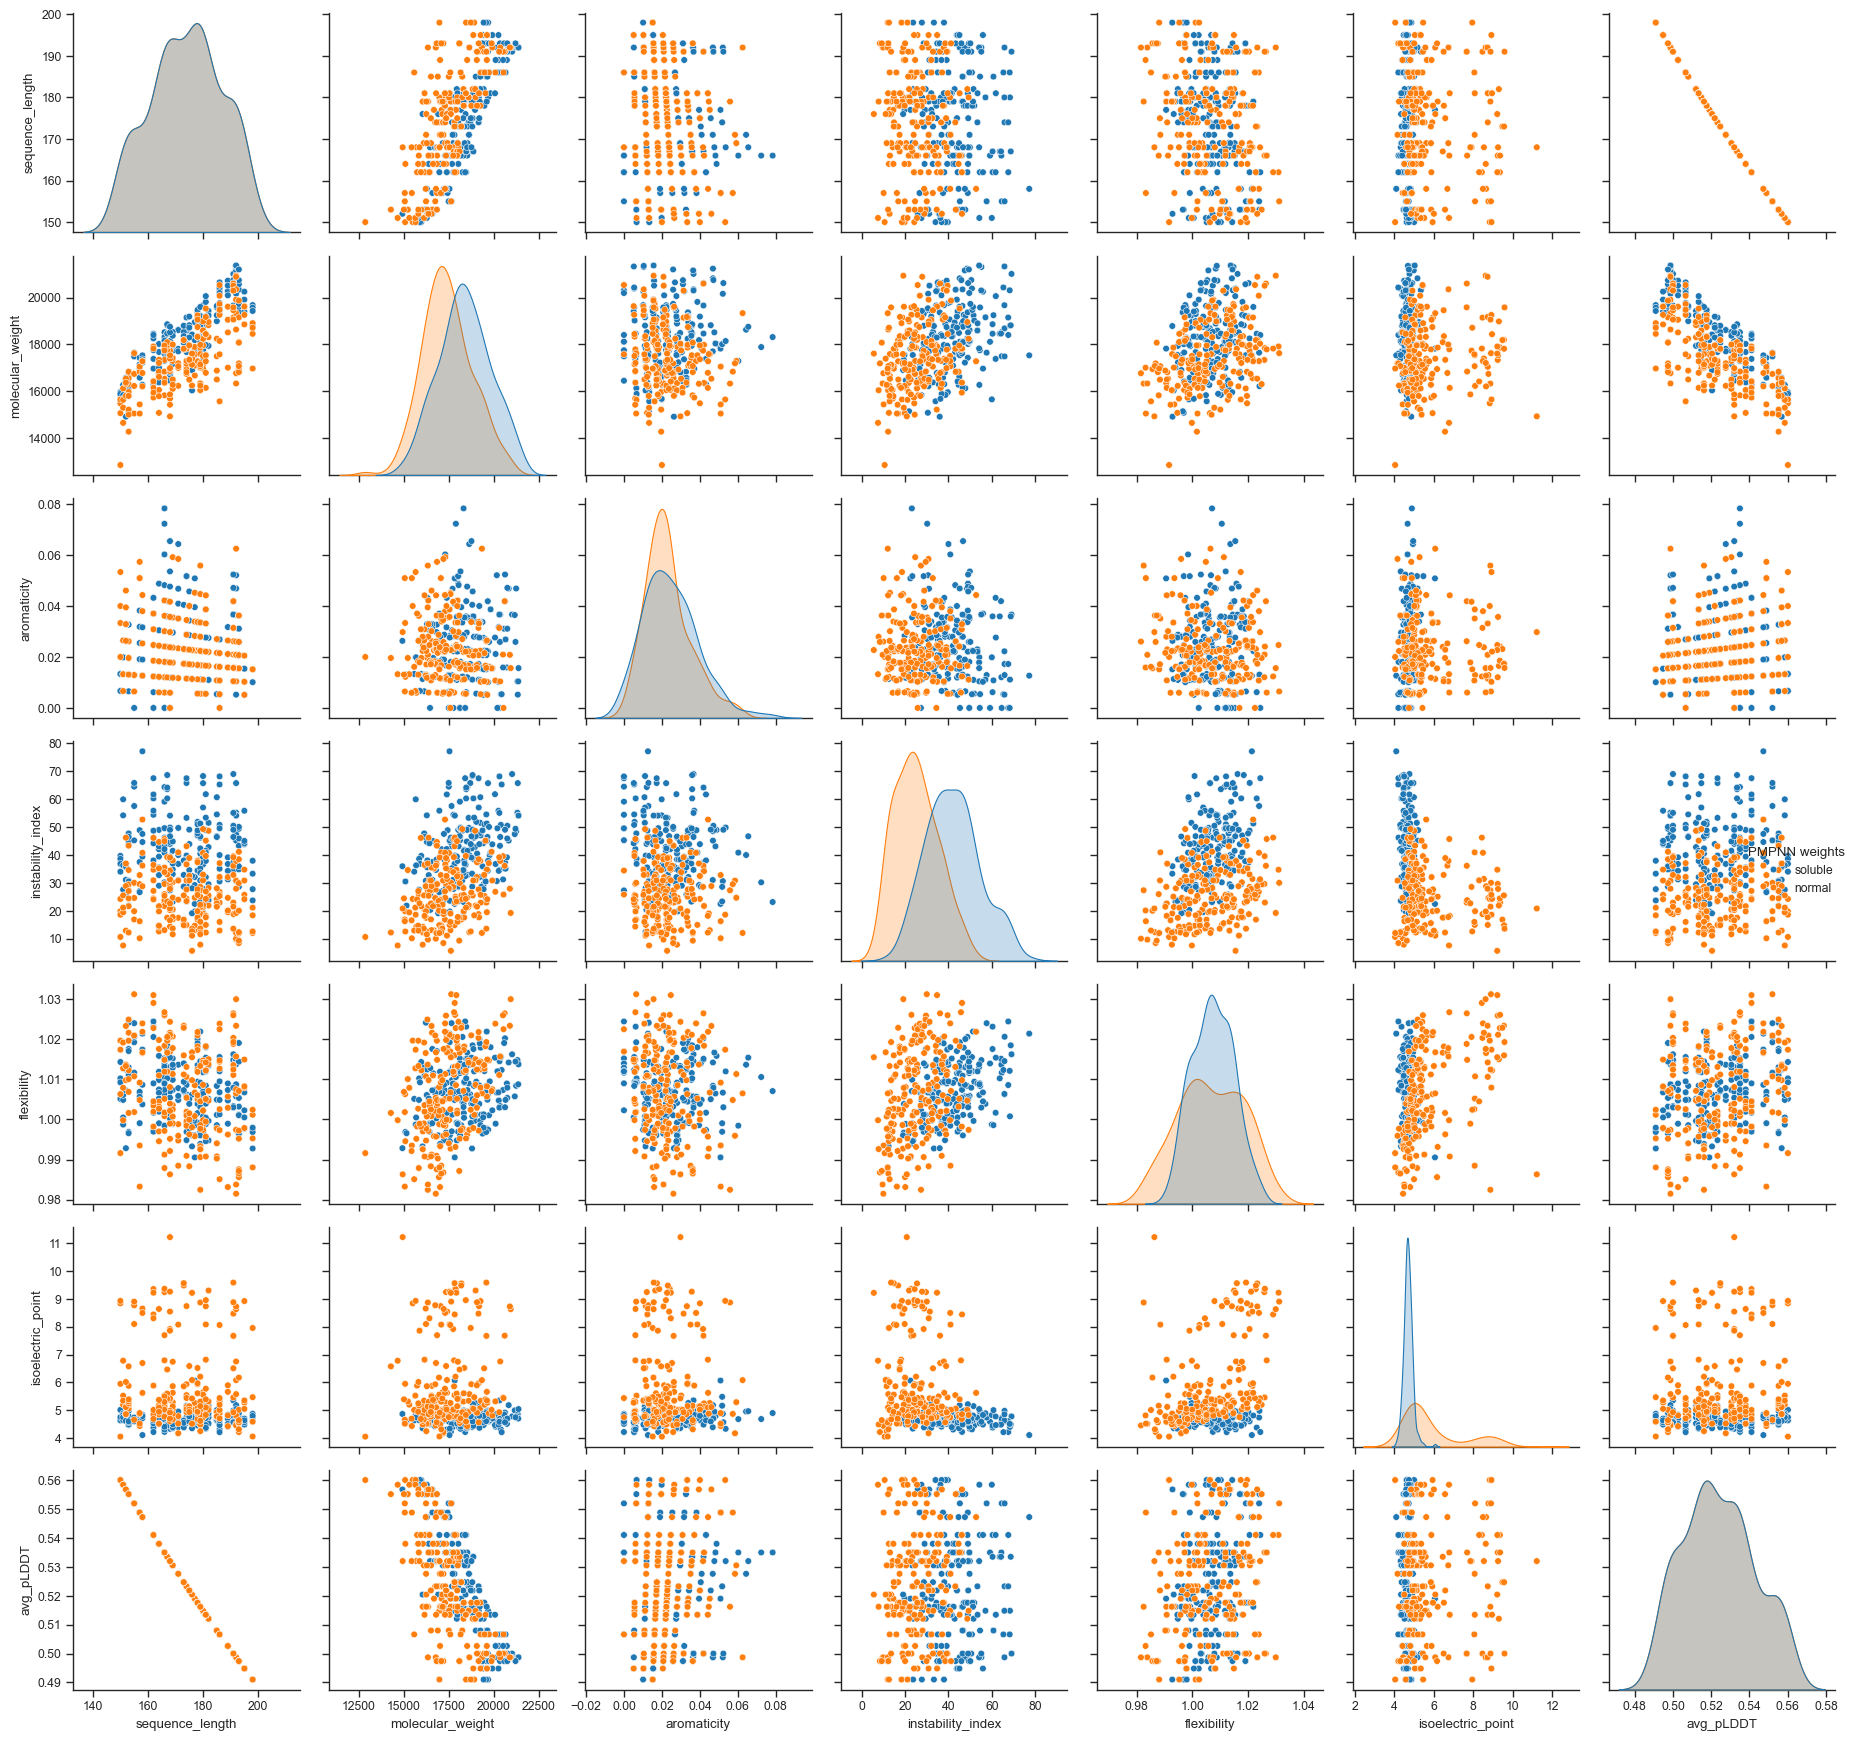

In [5]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(20,20),dpi=600) 
sns.pairplot(master_df, hue="PMPNN weights",)

plt.xticks(size=25)
plt.yticks(size=25)

plt.tight_layout()

plt.savefig('all_v_all_RFD_normal.png',transparent=True)
plt.show()

In [6]:
master_df = reduce_memory_usage(master_df)

Memory usage before reduction: 0.05 MB
Memory usage after reduction: 0.03 MB


In [7]:
normal_weights_final = master_df[master_df["PMPNN weights"]=='normal']
soluble_weights_final = master_df[master_df["PMPNN weights"]=='soluble']
master_df.to_csv(f'{rfdiff_dir}/master_df.csv')
del master_df

In [8]:
normal_weights_final = keep_top_score(normal_weights_final)
soluble_weights_final = keep_top_score(soluble_weights_final)
final_df = pd.concat([normal_weights_final,soluble_weights_final],axis=0).reset_index(drop=True)
RF_normal_df = final_df.copy()
del final_df

/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6496/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6496/1429492225.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6496/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

In [9]:
"./RF_diff/round1/beta_weights/PMPNN/normal_weights_chainA/"

'./RF_diff/round1/beta_weights/PMPNN/normal_weights_chainA/'

In [10]:
# Define your base directories
base_dir = Path("./RF_diff/round1/")
rfdiff_dir = base_dir / "beta_weights"
weights_dir = rfdiff_dir / "PMPNN" / "normal_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):

    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:

            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
normal_pmpnn_weight_df = pd.DataFrame(data)
normal_pmpnn_weight_df['PMPNN weights']='normal'

In [11]:
weights_dir = rfdiff_dir / "PMPNN" / "soluble_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):
    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:
            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
soluble_pmpnn_weight_df = pd.DataFrame(data)

soluble_pmpnn_weight_df['PMPNN weights']='soluble'
master_df = pd.concat([soluble_pmpnn_weight_df,normal_pmpnn_weight_df],axis=0, ignore_index=True)
master_df['sequence_length'] = master_df['sequence'].str.len()
master_df['RDiff_pdb_file_path'] = master_df['pdb_file'].apply(lambda x: f"{rfdiff_dir}/{x}.pdb")
master_df = master_df.dropna(subset=['seq_recovery']).reset_index(drop=True)

# Apply the analysis function to each sequence in the DataFrame
analysis_results = master_df['sequence'].apply(lambda x: analyze_protein(x))

# Split the results into separate columns and assign them back to the DataFrame
master_df[['molecular_weight', 'aromaticity', 'instability_index', 'flexibility', 'isoelectric_point']] = pd.DataFrame(analysis_results.tolist(), index=master_df.index)

master_df = pdb_to_value_df(df=master_df,
                value_name='avg_pLDDT',
               function=pdb_pLDDT)
print(f"Number of RFDiff PDBs = {len(master_df['pdb_file'].value_counts())}, total number of sequences = {len(master_df)}")

RF_diff/round1/beta_weights/_16.pdb
RF_diff/round1/beta_weights/_1.pdb
RF_diff/round1/beta_weights/_0.pdb
RF_diff/round1/beta_weights/_17.pdb
RF_diff/round1/beta_weights/_29.pdb
RF_diff/round1/beta_weights/_15.pdb
RF_diff/round1/beta_weights/_2.pdb
RF_diff/round1/beta_weights/_3.pdb
RF_diff/round1/beta_weights/_14.pdb
RF_diff/round1/beta_weights/_28.pdb
RF_diff/round1/beta_weights/_10.pdb
RF_diff/round1/beta_weights/_38.pdb
RF_diff/round1/beta_weights/_7.pdb
RF_diff/round1/beta_weights/_6.pdb
RF_diff/round1/beta_weights/_39.pdb
RF_diff/round1/beta_weights/_11.pdb
RF_diff/round1/beta_weights/_13.pdb
RF_diff/round1/beta_weights/_4.pdb
RF_diff/round1/beta_weights/_5.pdb
RF_diff/round1/beta_weights/_12.pdb
RF_diff/round1/beta_weights/_49.pdb
RF_diff/round1/beta_weights/_48.pdb
RF_diff/round1/beta_weights/_40.pdb
RF_diff/round1/beta_weights/_41.pdb
RF_diff/round1/beta_weights/_43.pdb
RF_diff/round1/beta_weights/_42.pdb
RF_diff/round1/beta_weights/_46.pdb
RF_diff/round1/beta_weights/_47.pdb


<Figure size 640x480 with 0 Axes>

<Figure size 12000x12000 with 0 Axes>

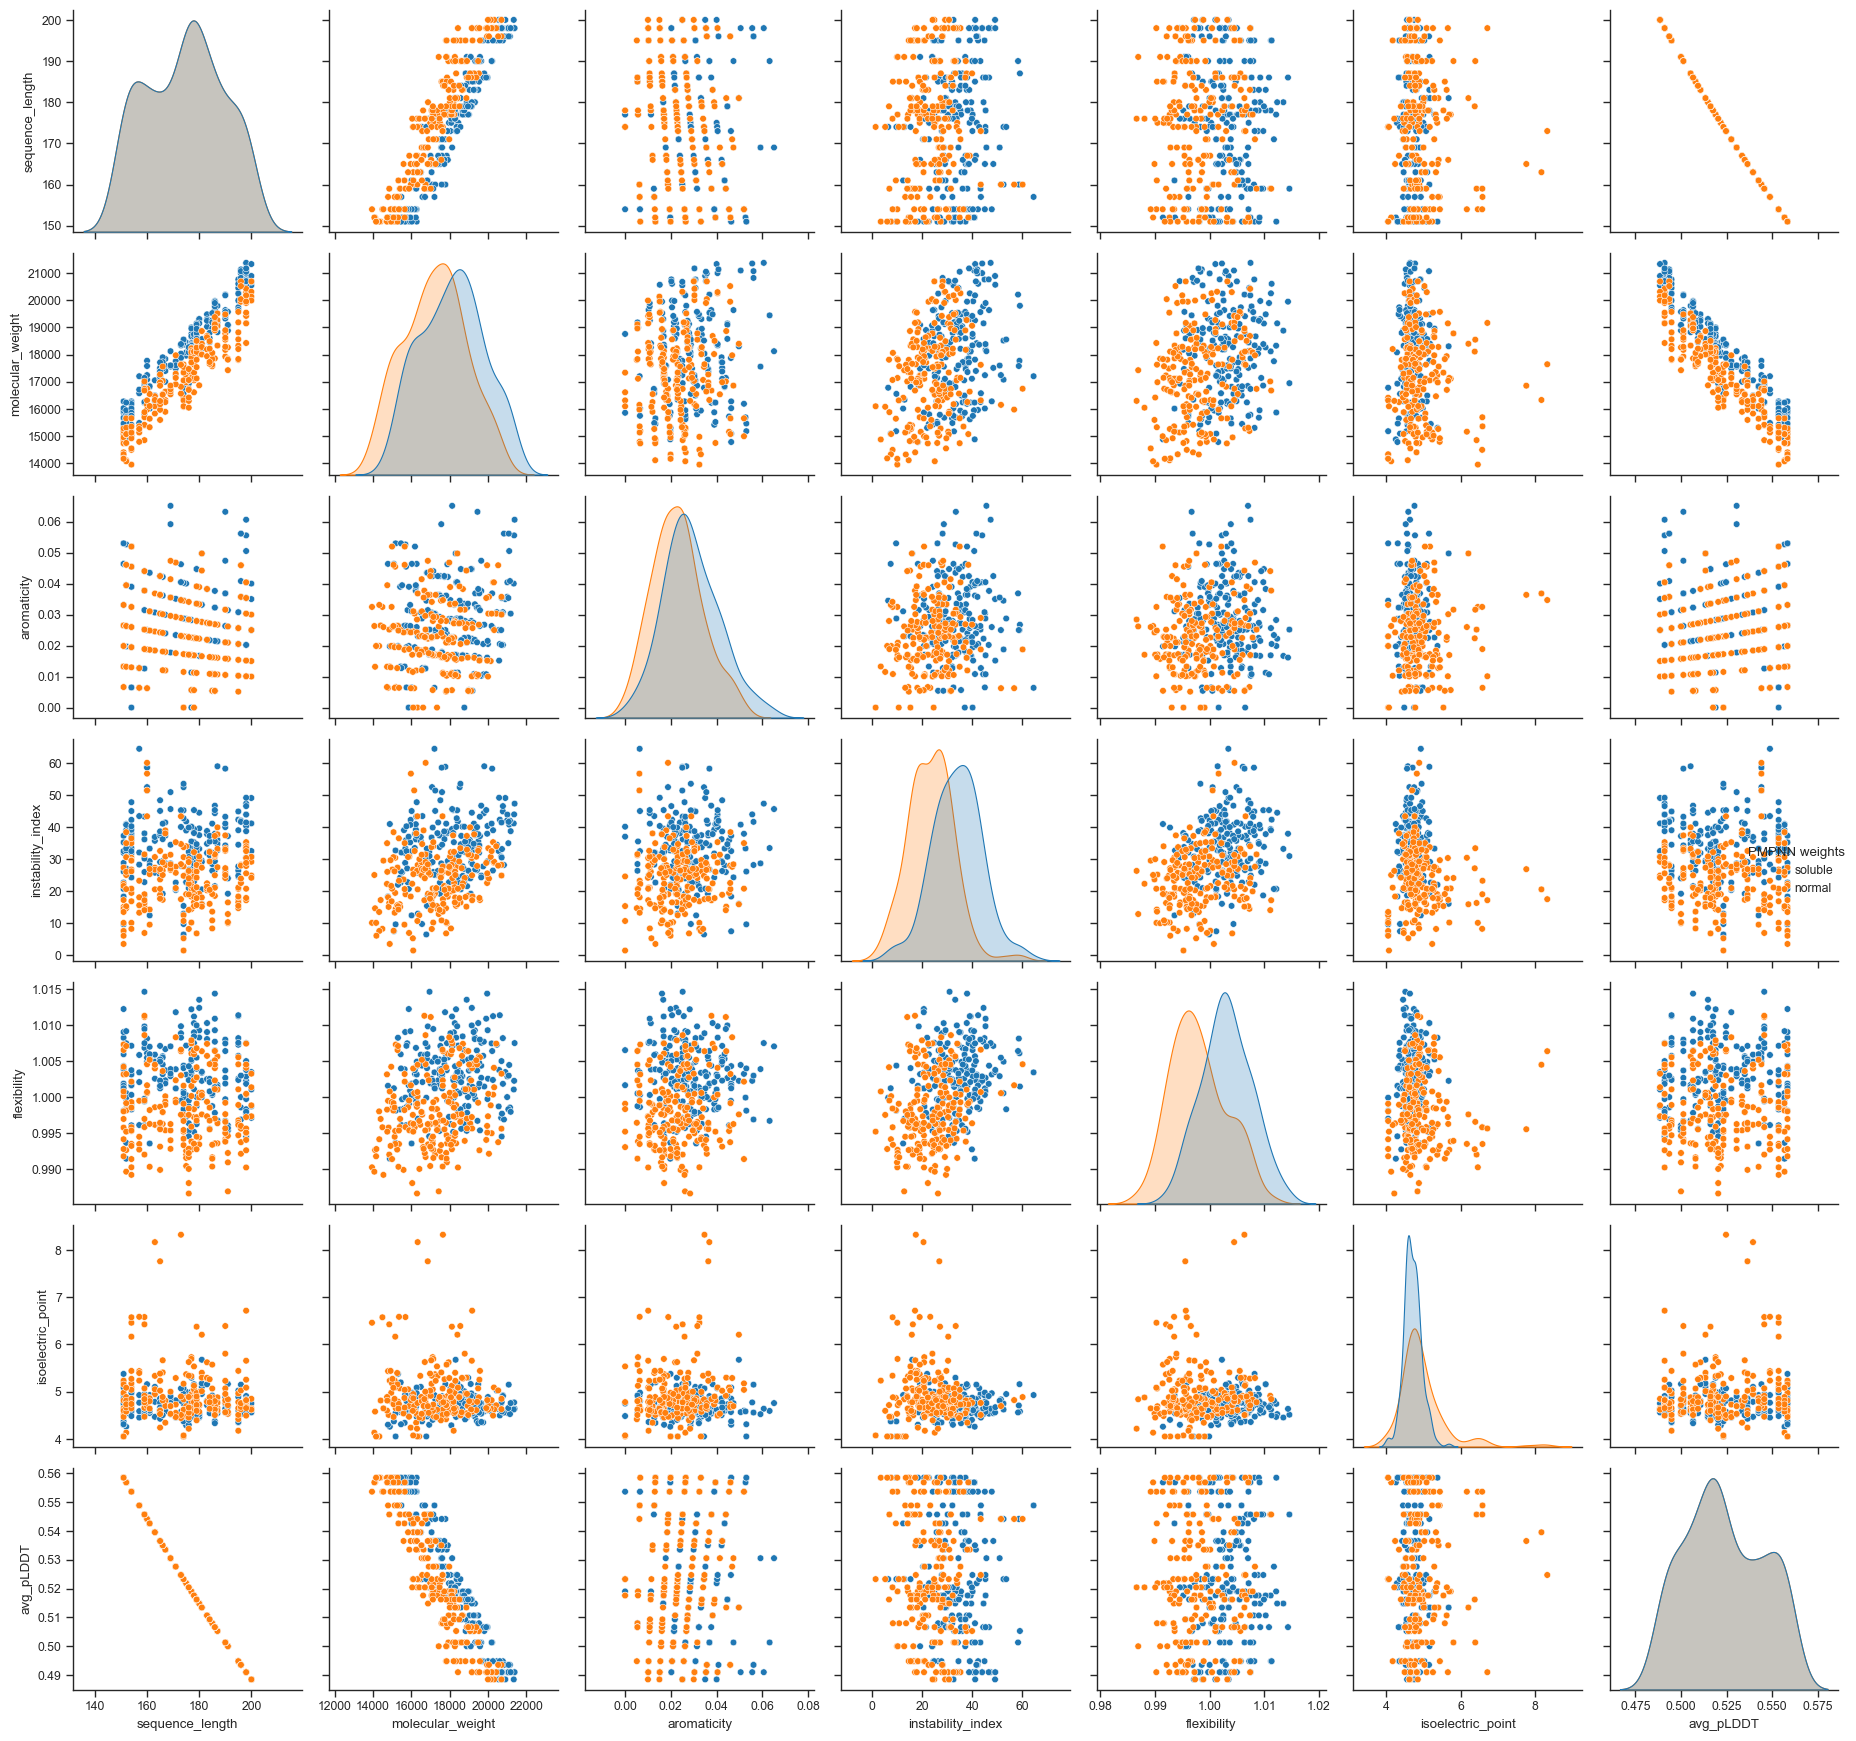

In [12]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(20,20),dpi=600) 
sns.pairplot(master_df, hue="PMPNN weights",)

plt.xticks(size=25)
plt.yticks(size=25)


plt.tight_layout()
plt.savefig('all_v_all_RFD_beta.png',transparent=True)
plt.show()


In [13]:
master_df = reduce_memory_usage(master_df)

Memory usage before reduction: 0.05 MB
Memory usage after reduction: 0.03 MB


In [14]:
normal_weights_final = master_df[master_df["PMPNN weights"]=='normal']
soluble_weights_final = master_df[master_df["PMPNN weights"]=='soluble']
master_df.to_csv(f'{rfdiff_dir}/master_df.csv')
del master_df

In [15]:
normal_weights_final = keep_top_score(normal_weights_final)
soluble_weights_final = keep_top_score(soluble_weights_final)
final_df = pd.concat([normal_weights_final,soluble_weights_final],axis=0).reset_index(drop=True)
RF_beta_df = final_df.copy()
del final_df

/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6496/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6496/1429492225.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6496/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

In [16]:
RF_beta_df['RF_weights']='Beta'
RF_normal_df['RF_weights']='Normal'

In [17]:
RF_beta_df

pdb_file                                           sequence   score  \
0        _0  VEEVKKLASEIIEEVAAQMLAAHDYVLVGVVSTEPLEVKALPGQVV...  0.8813   
1        _1  EETLRRAEEAAAALGATITVSSTYEGAANAASAVAANMGAVLVAVA...  0.8962   
2       _10  MKAAVVAISSTLDGAQYALNMGRNLAKAAGAEVTEATFTTEEREEA...  0.9317   
3       _11  GADAAADACEAAARAVAAEAGMAVAVVRFTDKDSLAEARAAIAAAA...  0.8781   
4       _12  TATATATCEAKVSITVGTEDATVTVTATATVTATSSNPDDTVTVTL...  0.7990   
..      ...                                                ...     ...   
95       _5  AKLFVNVGSGLIRSLYEDQIAAAEAAGEFTILVSPVKILEGSSGKK...  0.9018   
96       _6  MANVVPAGINVSASSTLDSIDADAAAARATIEEALANGDKVALHVN...  0.8795   
97       _7  MSEGYVSITISSREVAEEGLEKVLEEIEKKFEEAKELAKKHDVLHI...  0.8068   
98       _8  MKPELEYSVSVKIIREEATGDSPEVREAIVKAAEEACRAVKEETKE...  0.9135   
99       _9  SVSLSASAVAVDEGGAVAAAGDLVTATAAALDEIAAKLSDEDLVFV...  0.9651   

   global_score seq_recovery  \
0        1.2260       0.0514   
1        1.2239       0.0778   
2        1.2481       0.0699   
3        1.2786       0.0573   
4        1.1941       0.0920   
..          ...          ...   
95       1.2367       0.0855   
96       1.2056       0.0718   
97       1.1969       0.0667   
98       1.2448       0.0492   
99       1.2482       0.0714   

                                      fasta_file_path PMPNN weights  \
0   RF_diff/round1/beta_weights/PMPNN/normal_weigh...        normal   
1   RF_diff/round1/beta_weights/PMPNN/normal_weigh...        normal   
2   RF_diff/round1/beta_weights/PMPNN/normal_weigh...        normal   
3   RF_diff/round1/beta_weights/PMPNN/normal_weigh...        normal   
4   RF_diff/round1/beta_weights/PMPNN/normal_weigh...        normal   
..                                                ...           ...   
95  RF_diff/round1/beta_weights/PMPNN/soluble_weig...       soluble   
96  RF_diff/round1/beta_weights/PMPNN/soluble_weig...       soluble   
97  RF_diff/round1/beta_weights/PMPNN/soluble_weig...       soluble   
98  RF_diff/round1/beta_weights/PMPNN/soluble_weig...       soluble   
99  RF_diff/round1/beta_weights/PMPNN/soluble_weig...       soluble   

    sequence_length                  RDiff_pdb_file_path  molecular_weight  \
0               175   RF_diff/round1/beta_weights/_0.pdb           17152.0   
1               167   RF_diff/round1/beta_weights/_1.pdb           16256.0   
2               186  RF_diff/round1/beta_weights/_10.pdb           19168.0   
3               157  RF_diff/round1/beta_weights/_11.pdb           15264.0   
4               174  RF_diff/round1/beta_weights/_12.pdb           16312.0   
..              ...                                  ...               ...   
95              152   RF_diff/round1/beta_weights/_5.pdb           15176.0   
96              195   RF_diff/round1/beta_weights/_6.pdb           19648.0   
97              195   RF_diff/round1/beta_weights/_7.pdb           20256.0   
98              183   RF_diff/round1/beta_weights/_8.pdb           19248.0   
99              196   RF_diff/round1/beta_weights/_9.pdb           20832.0   

    aromaticity  instability_index  flexibility  isoelectric_point  avg_pLDDT  \
0      0.022858          33.937500     0.991699           4.484375   0.521973   
1      0.011978          37.968750     0.999023           4.343750   0.533691   
2      0.026886          24.875000     1.003906           4.574219   0.506836   
3      0.012741          15.500000     0.992676           5.394531   0.548828   
4      0.000000          10.585938     0.999023           4.050781   0.523438   
..          ...                ...          ...                ...        ...   
95     0.019730          32.656250     0.993652           4.539062   0.556641   
96     0.010254          24.781250     1.007812           4.355469   0.494873   
97     0.025635          38.968750     1.011719           4.617188   0.494873   
98     0.027328          34.750000     1.008789           4.714844   0.510742   
99     0.056122          28.093750     0.997070 

In [18]:
final_df = pd.concat([RF_normal_df,RF_beta_df],axis=0).reset_index(drop=True)


In [19]:
def write_fasta_files(df, folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Iterate over rows of the dataframe
    for index, row in df.iterrows():
        # Generate the filename for the FASTA file using the pdb_file column
        file_name = f"{row['PMPNN weights']}{row['pdb_file']}.fasta"
        file_path = os.path.join(folder_path, file_name)
        
        # Write the sequence to the FASTA file
        with open(file_path, "w") as fasta_file:
            fasta_file.write(f">{index}\n")
            fasta_file.write(f"{row['sequence']}\n")
        
        # Update the dataframe with the file path
        df.at[index, 'fasta_path'] = file_path
    
    return df


folder_path = "./att1/RF_beta/all_fastas"
RF_beta_df = write_fasta_files(RF_beta_df, folder_path)
folder_path = "./att1/RF_normal/all_fastas"
RF_normal_df = write_fasta_files(RF_normal_df, folder_path)

<Figure size 640x480 with 0 Axes>

<Figure size 19200x19200 with 0 Axes>

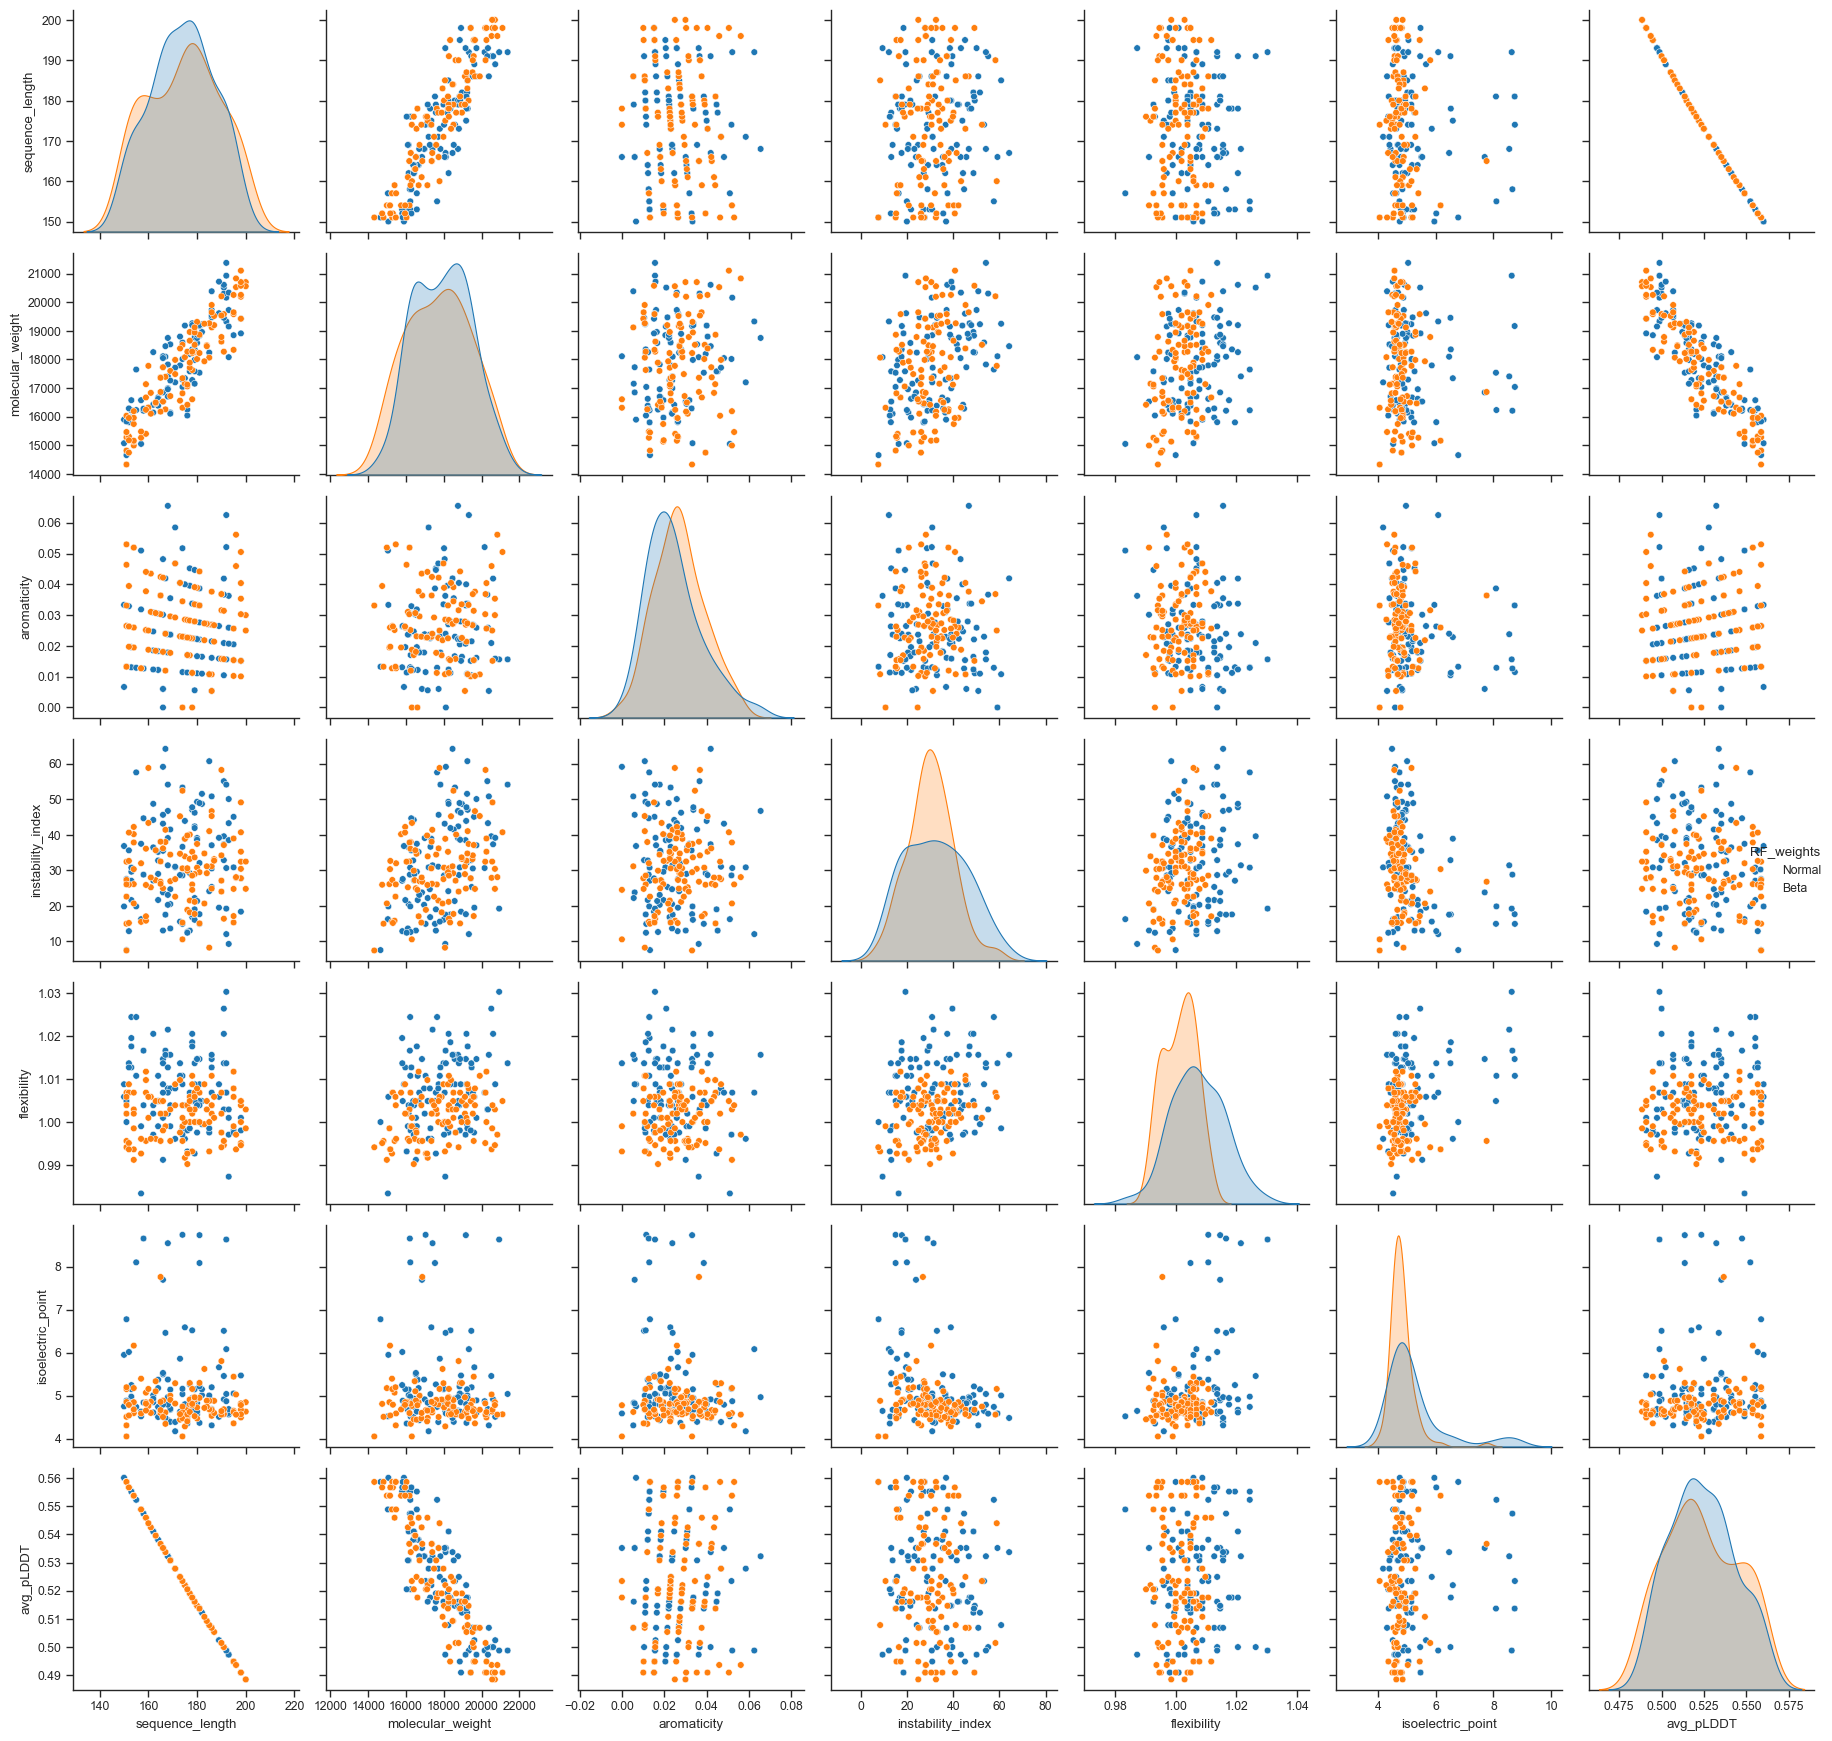

In [20]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(32,32),dpi=600) 
sns.pairplot(final_df, hue="RF_weights",)

plt.xticks(size=25)
plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_RFD_weights.png',transparent=True)
plt.show()

In [21]:
!pwd

/Users/phr361/Documents/Coding/ProteinDesign/AntiAntiDefence/ProteinDesignCompAug


/Users/phr361/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [22]:
mapping_dict = {
    'normal': 'normal',
    'soluble': 'soluble'
}
path_to_ESM = './att1/RF_beta/ESM_outputs/'

# Function to map pdb_file to result file path
def map_result_path(row):
    
    def find_pdb_file(pdb_dir):
        try:
            pdb_files = [f for f in os.listdir(pdb_dir) if f.endswith('.pdb')]
            if pdb_files:
                return os.path.join(pdb_dir, pdb_files[0])
            else:
                return None
        except FileNotFoundError:
            return None
    
    weight_type = mapping_dict.get(row['PMPNN weights'])
    pdb_number = row['pdb_file']
    result_file = f"{weight_type}{pdb_number}_result/"
    result_path = os.path.join(path_to_ESM, result_file)
    result = find_pdb_file(result_path)
    print(result)
    return result

RF_beta_df['ESM_pdb_path'] = RF_beta_df.apply(map_result_path, axis=1)




None
./att1/RF_beta/ESM_outputs/normal_1_result/1.pdb
./att1/RF_beta/ESM_outputs/normal_10_result/2.pdb
./att1/RF_beta/ESM_outputs/normal_11_result/3.pdb
./att1/RF_beta/ESM_outputs/normal_12_result/4.pdb
./att1/RF_beta/ESM_outputs/normal_13_result/5.pdb
./att1/RF_beta/ESM_outputs/normal_14_result/6.pdb
./att1/RF_beta/ESM_outputs/normal_15_result/7.pdb
./att1/RF_beta/ESM_outputs/normal_16_result/8.pdb
./att1/RF_beta/ESM_outputs/normal_17_result/9.pdb
./att1/RF_beta/ESM_outputs/normal_18_result/10.pdb
./att1/RF_beta/ESM_outputs/normal_19_result/11.pdb
./att1/RF_beta/ESM_outputs/normal_2_result/12.pdb
./att1/RF_beta/ESM_outputs/normal_20_result/13.pdb
./att1/RF_beta/ESM_outputs/normal_21_result/14.pdb
./att1/RF_beta/ESM_outputs/normal_22_result/15.pdb
./att1/RF_beta/ESM_outputs/normal_23_result/16.pdb
./att1/RF_beta/ESM_outputs/normal_24_result/17.pdb
./att1/RF_beta/ESM_outputs/normal_25_result/18.pdb
./att1/RF_beta/ESM_outputs/normal_26_result/19.pdb
./att1/RF_beta/ESM_outputs/normal_27_

In [23]:
# Apply the function to create the new column
path_to_ESM = './att1/RF_normal/ESM_outputs/'

RF_normal_df['ESM_pdb_path'] = RF_normal_df.apply(map_result_path, axis=1)

None
./att1/RF_normal/ESM_outputs/normal_1_result/1.pdb
./att1/RF_normal/ESM_outputs/normal_10_result/2.pdb
./att1/RF_normal/ESM_outputs/normal_11_result/3.pdb
./att1/RF_normal/ESM_outputs/normal_12_result/4.pdb
./att1/RF_normal/ESM_outputs/normal_13_result/5.pdb
./att1/RF_normal/ESM_outputs/normal_14_result/6.pdb
./att1/RF_normal/ESM_outputs/normal_15_result/7.pdb
./att1/RF_normal/ESM_outputs/normal_16_result/8.pdb
./att1/RF_normal/ESM_outputs/normal_17_result/9.pdb
./att1/RF_normal/ESM_outputs/normal_18_result/10.pdb
./att1/RF_normal/ESM_outputs/normal_19_result/11.pdb
./att1/RF_normal/ESM_outputs/normal_2_result/12.pdb
./att1/RF_normal/ESM_outputs/normal_20_result/13.pdb
./att1/RF_normal/ESM_outputs/normal_21_result/14.pdb
./att1/RF_normal/ESM_outputs/normal_22_result/15.pdb
./att1/RF_normal/ESM_outputs/normal_23_result/16.pdb
./att1/RF_normal/ESM_outputs/normal_24_result/17.pdb
./att1/RF_normal/ESM_outputs/normal_25_result/18.pdb
./att1/RF_normal/ESM_outputs/normal_26_result/19.pdb

In [24]:

from Bio.PDB import PDBParser, PDBIO, Select


def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def extract_chain_and_save(df, pdb_column,  new_pdb_folder, new_column_name,chain_id=0):
    
    ensure_directory(new_pdb_folder)
    
    for index, row in df.iterrows():
        pdb_path = row[pdb_column]
        
        base_pdb_path, _ = os.path.splitext(os.path.basename(pdb_path))

        new_pdb_path = os.path.join(new_pdb_folder, f"{base_pdb_path}_{chain_id}.pdb")
        
        try:
            assembly = ampal.load_pdb(pdb_path)
            chain = assembly[chain_id]
            A=open(new_pdb_path,'w')
            print(chain.pdb,file=A)
            A.close()

            df.at[index, new_column_name] = new_pdb_path
        except Exception as e:
            print(f"Error processing file {pdb_path}: {e}")

    return df


In [25]:
df = RF_beta_df.copy()
pdb_column = 'RDiff_pdb_file_path'
chain_id = 'A'
new_pdb_folder = './att1/RF_beta/RFDiff_files/binders_only'

new_column_name = 'RFDiff_binder_pdb_path'

RF_beta_df = extract_chain_and_save(df, pdb_column, 
                                                new_pdb_folder, 
                                                new_column_name)


In [26]:
df = RF_normal_df.copy()
pdb_column = 'RDiff_pdb_file_path'
chain_id = 'A'
new_pdb_folder = './att1/RF_normal/RFDiff_files/binders_only'

new_column_name = 'RFDiff_binder_pdb_path'

RF_normal_df = extract_chain_and_save(df, pdb_column,  
                                                new_pdb_folder, 
                                                new_column_name)


In [27]:
RF_normal_df['ESM_pdb_path'].replace({None: np.nan}, inplace=True)
RF_beta_df['ESM_pdb_path'].replace({None: np.nan}, inplace=True)

In [28]:
final_df = pd.concat([RF_beta_df,RF_normal_df],axis=0).reset_index(drop=True)


In [29]:
final_df=final_df.dropna()
final_df=final_df.reset_index()

In [30]:
final_df = pdb_to_value_df(df=final_df,
                value_name='ESMFold_pLDDT',
               function=pdb_pLDDT,pdb_path_column='ESM_pdb_path')

./att1/RF_beta/ESM_outputs/normal_1_result/1.pdb
./att1/RF_beta/ESM_outputs/normal_10_result/2.pdb
./att1/RF_beta/ESM_outputs/normal_11_result/3.pdb
./att1/RF_beta/ESM_outputs/normal_12_result/4.pdb
./att1/RF_beta/ESM_outputs/normal_13_result/5.pdb
./att1/RF_beta/ESM_outputs/normal_14_result/6.pdb
./att1/RF_beta/ESM_outputs/normal_15_result/7.pdb
./att1/RF_beta/ESM_outputs/normal_16_result/8.pdb
./att1/RF_beta/ESM_outputs/normal_17_result/9.pdb
./att1/RF_beta/ESM_outputs/normal_18_result/10.pdb
./att1/RF_beta/ESM_outputs/normal_19_result/11.pdb
./att1/RF_beta/ESM_outputs/normal_2_result/12.pdb
./att1/RF_beta/ESM_outputs/normal_20_result/13.pdb
./att1/RF_beta/ESM_outputs/normal_21_result/14.pdb
./att1/RF_beta/ESM_outputs/normal_22_result/15.pdb
./att1/RF_beta/ESM_outputs/normal_23_result/16.pdb
./att1/RF_beta/ESM_outputs/normal_24_result/17.pdb
./att1/RF_beta/ESM_outputs/normal_25_result/18.pdb
./att1/RF_beta/ESM_outputs/normal_26_result/19.pdb
./att1/RF_beta/ESM_outputs/normal_27_resul

./att1/RF_normal/ESM_outputs/soluble_3_result/73.pdb
./att1/RF_normal/ESM_outputs/soluble_30_result/74.pdb
./att1/RF_normal/ESM_outputs/soluble_31_result/75.pdb
./att1/RF_normal/ESM_outputs/soluble_32_result/76.pdb
./att1/RF_normal/ESM_outputs/soluble_33_result/77.pdb
./att1/RF_normal/ESM_outputs/soluble_34_result/78.pdb
./att1/RF_normal/ESM_outputs/soluble_35_result/79.pdb
./att1/RF_normal/ESM_outputs/soluble_36_result/80.pdb
./att1/RF_normal/ESM_outputs/soluble_37_result/81.pdb
./att1/RF_normal/ESM_outputs/soluble_38_result/82.pdb
./att1/RF_normal/ESM_outputs/soluble_39_result/83.pdb
./att1/RF_normal/ESM_outputs/soluble_4_result/84.pdb
./att1/RF_normal/ESM_outputs/soluble_40_result/85.pdb
./att1/RF_normal/ESM_outputs/soluble_41_result/86.pdb
./att1/RF_normal/ESM_outputs/soluble_42_result/87.pdb
./att1/RF_normal/ESM_outputs/soluble_43_result/88.pdb
./att1/RF_normal/ESM_outputs/soluble_44_result/89.pdb
./att1/RF_normal/ESM_outputs/soluble_45_result/90.pdb
./att1/RF_normal/ESM_outputs/s

In [31]:
import nglview
pdb_of_interest = final_df['RDiff_pdb_file_path'][0]
view = nglview.show_structure_file(pdb_of_interest) 
view

NGLWidget()

In [32]:
pdb_of_interest = final_df['RFDiff_binder_pdb_path'][0]
view = nglview.show_structure_file(pdb_of_interest) 
view

NGLWidget()

In [33]:
pdb_of_interest = final_df['ESM_pdb_path'][0]
view = nglview.show_structure_file(pdb_of_interest) 
view

NGLWidget()

In [34]:
def add_TM_score_to_df(row):
    pdb_path = row['ESM_pdb_path']
    rdiff_pdb_path = row['RFDiff_binder_pdb_path']
    tm_score = protein_design_utils.TM_score(pdb_path, rdiff_pdb_path)
    return tm_score

# Applying the function to each row of the DataFrame
final_df['RFDiff_ESM_TM_score'] = final_df.apply(add_TM_score_to_df, axis=1)



No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the outp

################
###Saving data and plot###
################


<Figure size 640x480 with 0 Axes>

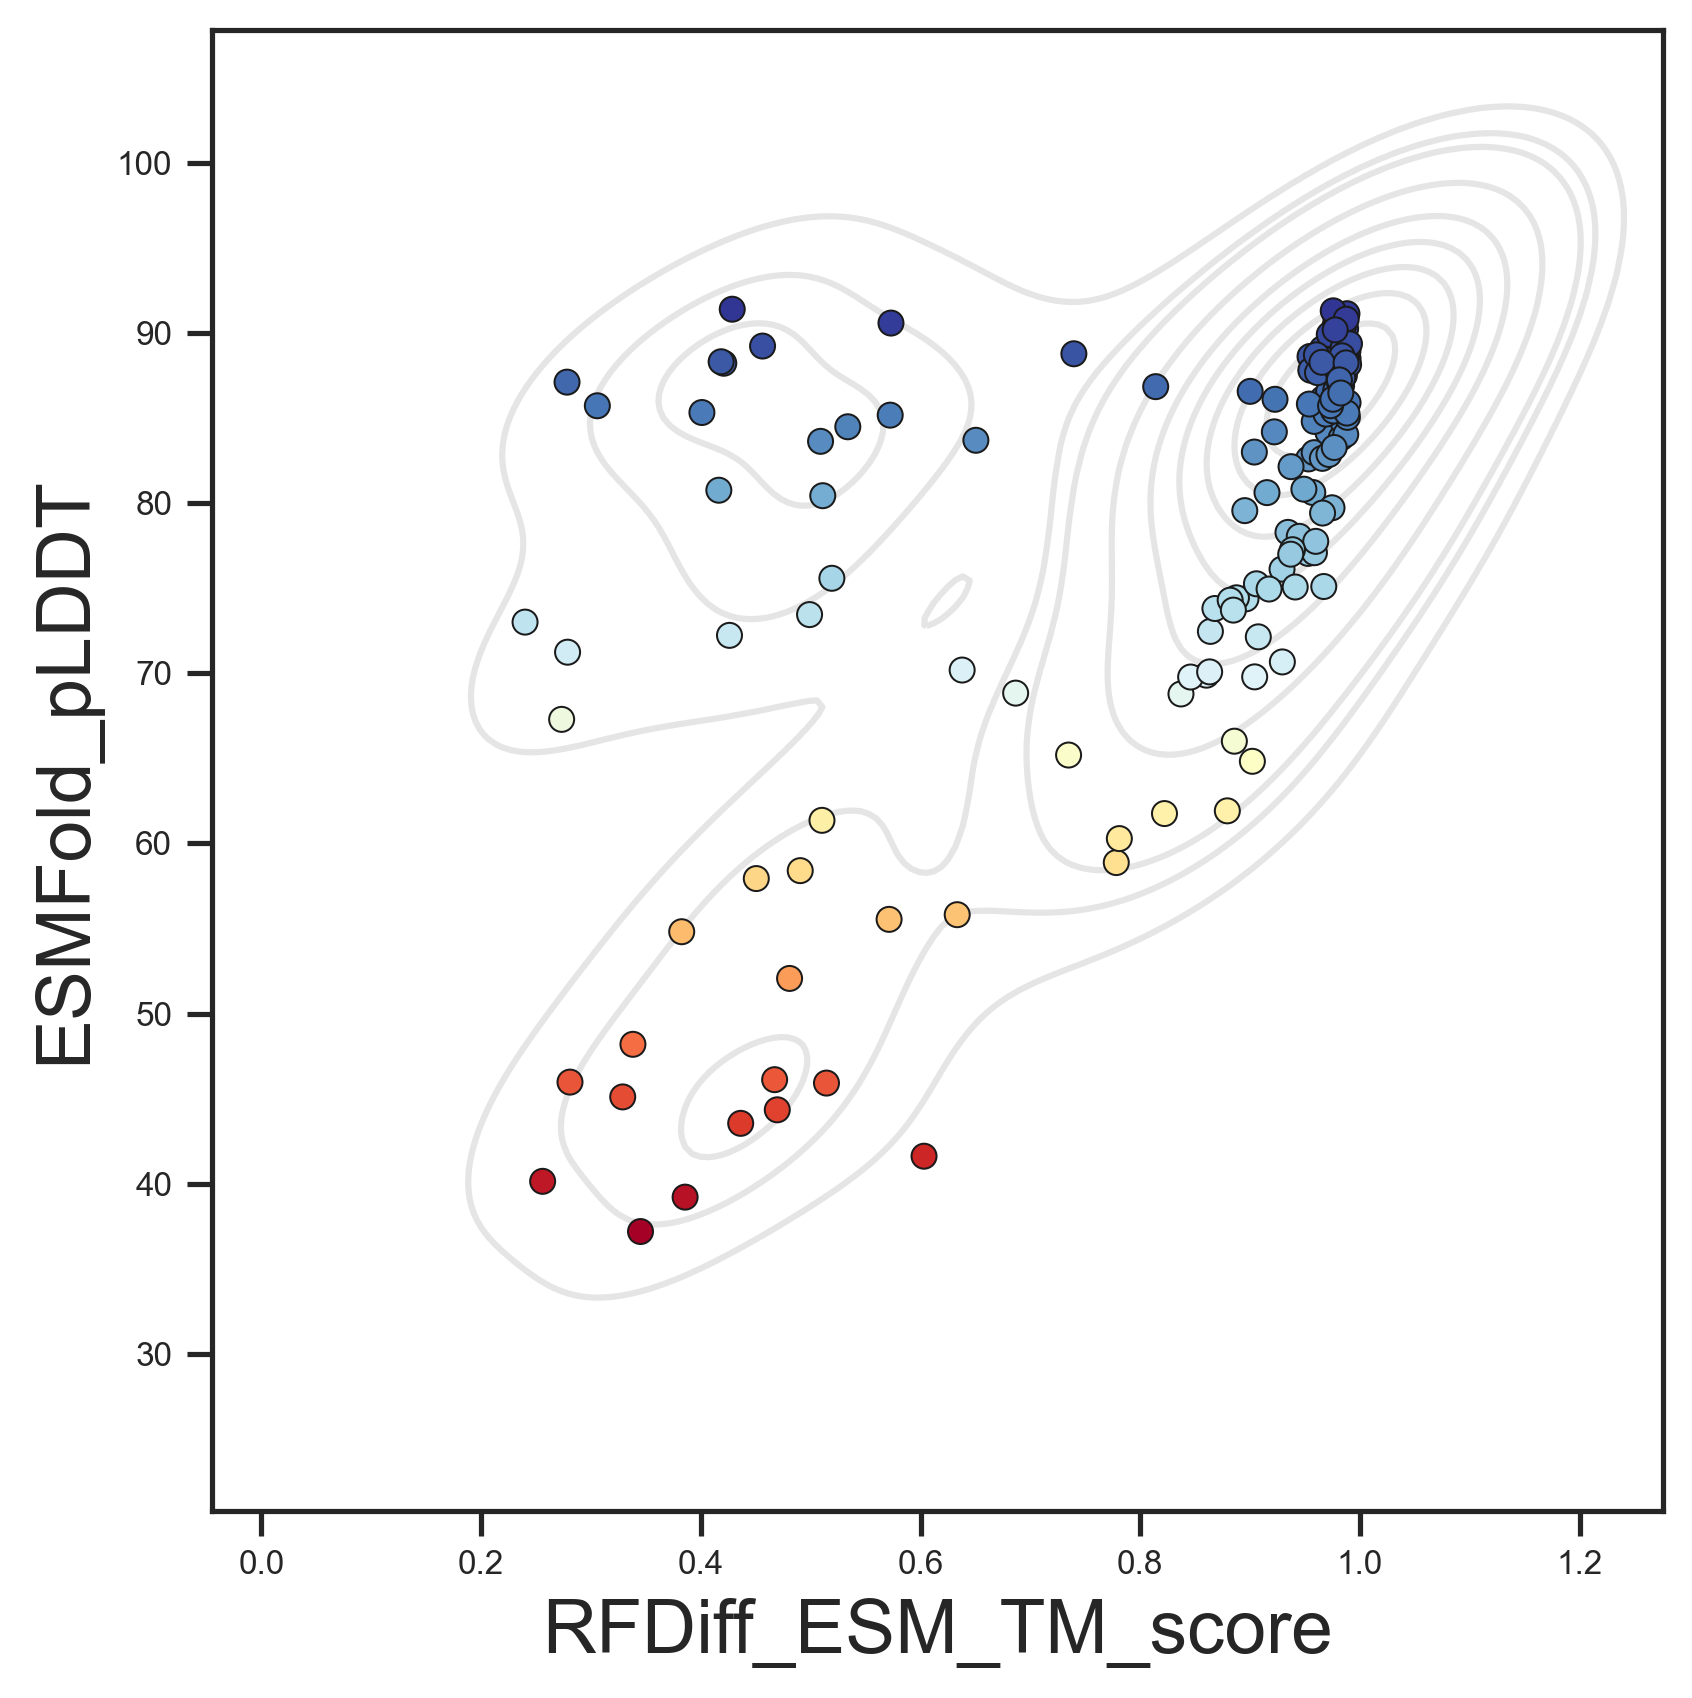

In [35]:
fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu='ESMFold_pLDDT'
df=final_df.copy()
sns.scatterplot(data=df,x='RFDiff_ESM_TM_score',y='ESMFold_pLDDT',hue=hu,sizes='RFDiff_ESM_TM_score',palette='RdYlBu',edgecolor='k')
sns.kdeplot(data=df,x='RFDiff_ESM_TM_score',y='ESMFold_pLDDT',color='grey',levels=10,alpha=0.2,zorder=-1)

#plt.legend(title=hu,loc=(1.1,0.1))
plt.legend('',frameon=False)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


################
###Saving data and plot###
################


<Figure size 640x480 with 0 Axes>

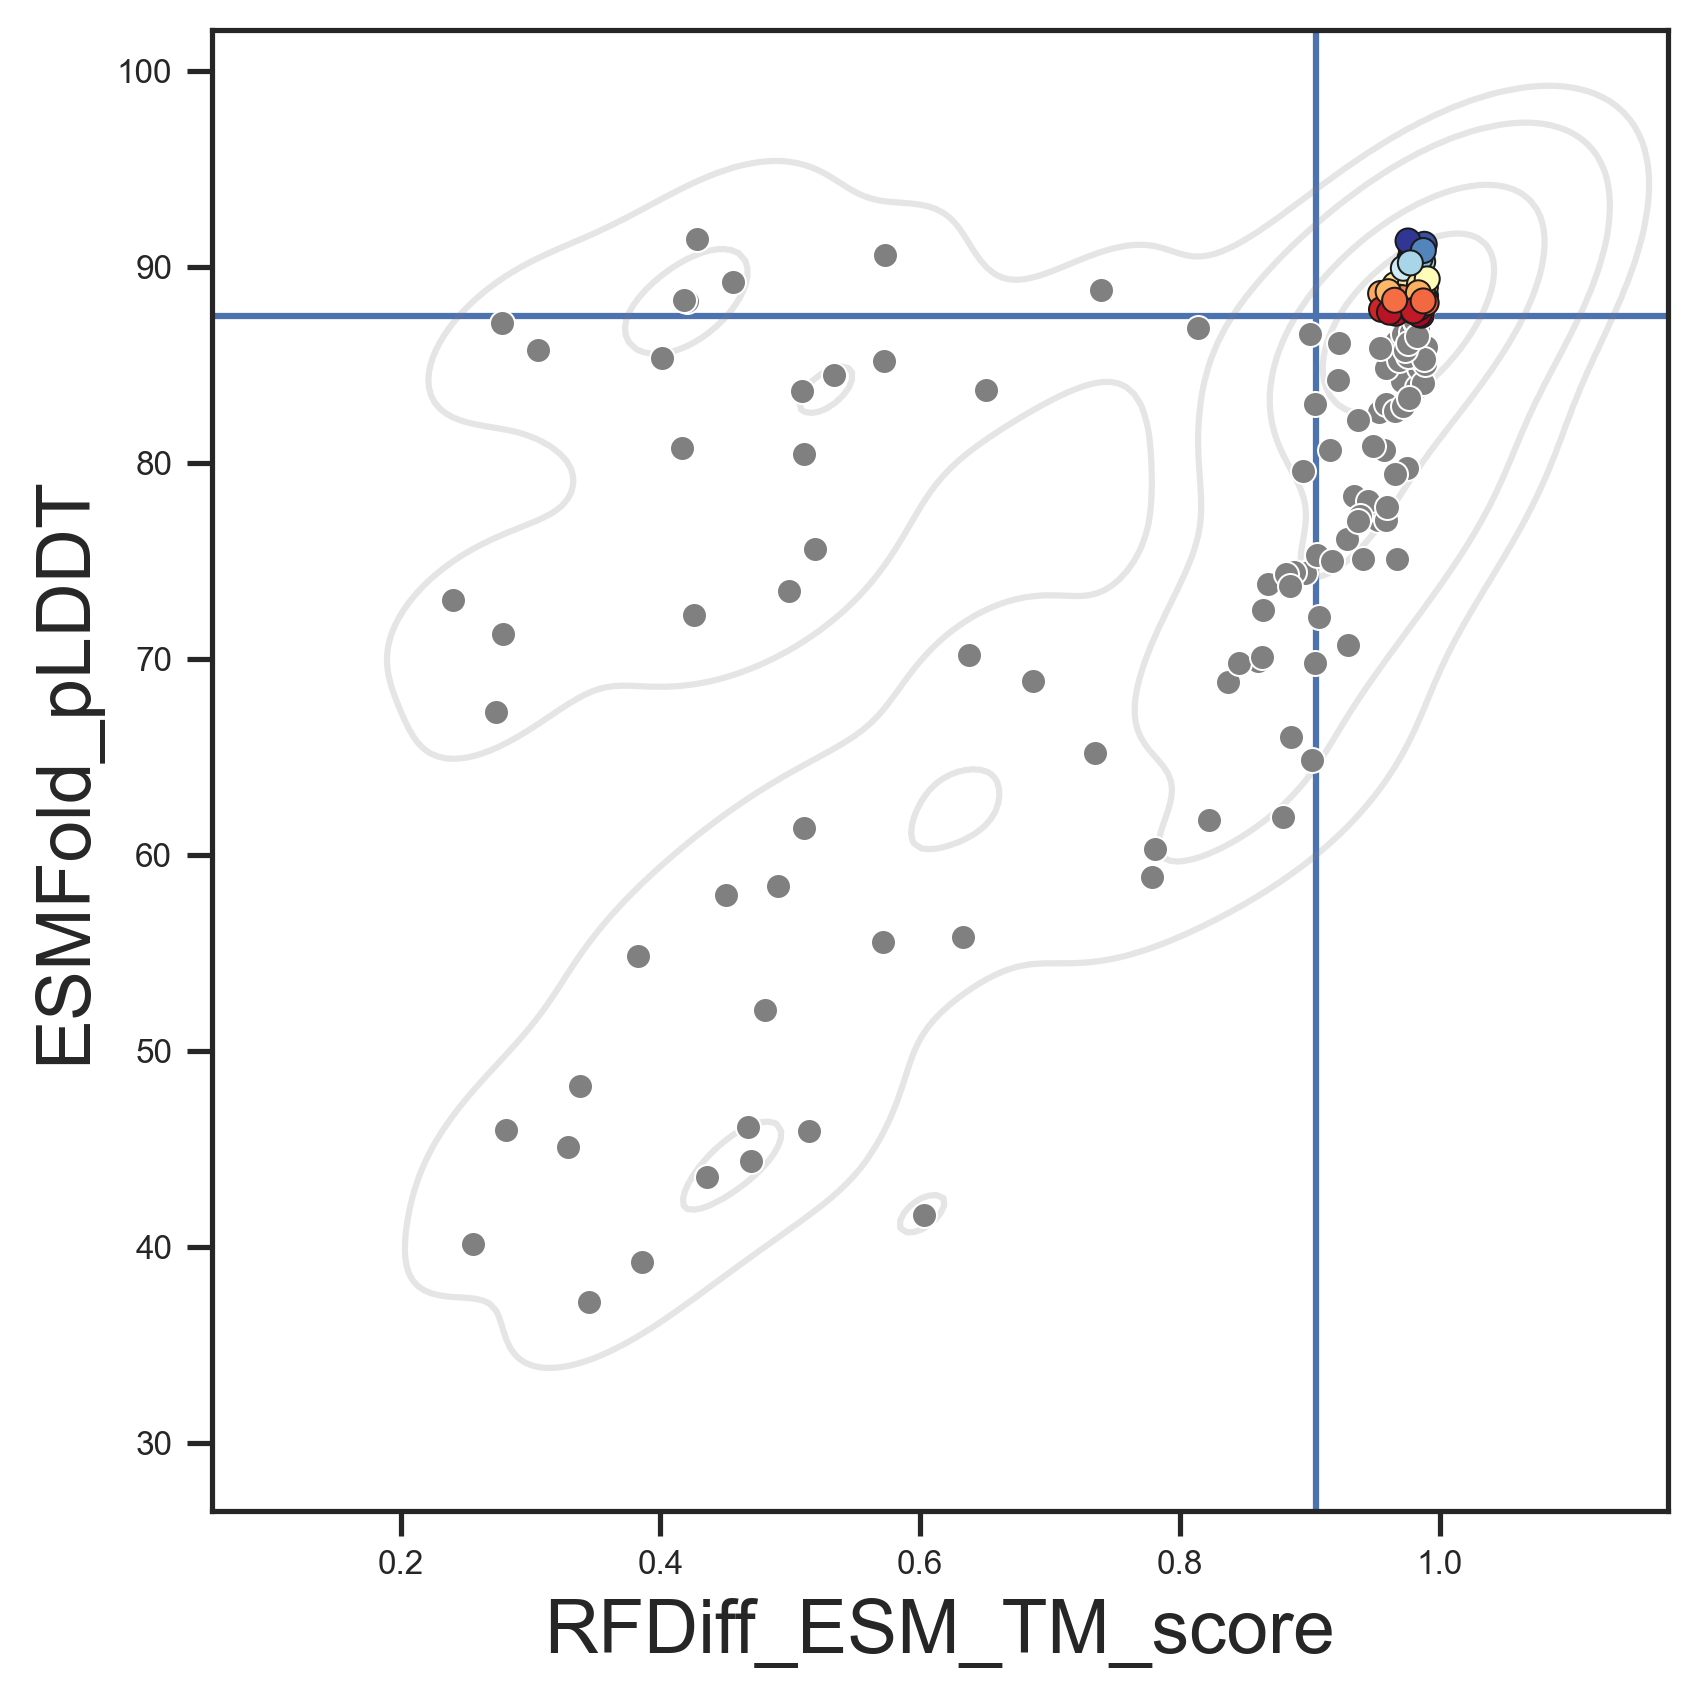

In [36]:
df=final_df.copy()

cut_TM = 0.905 #0.26
cut_pLDDT = 0.875*100

TM_col_name = 'RFDiff_ESM_TM_score'
pLDDT_col_name = 'ESMFold_pLDDT'
df_TM = df[df[TM_col_name]>cut_TM]
df_pLDDT = df_TM[df_TM[pLDDT_col_name]>cut_pLDDT]
df_best = df_pLDDT[df_pLDDT[TM_col_name]>cut_TM]

fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu=pLDDT_col_name

plt.axhline(y=cut_pLDDT,zorder=-2)
plt.axvline(x=cut_TM,zorder=-2)

sns.scatterplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',zorder=0)
sns.scatterplot(data=df_best,x=TM_col_name,y=pLDDT_col_name,hue=hu,palette='RdYlBu',edgecolor='k',zorder=1)

sns.kdeplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',bw_adjust=0.65,levels=5,alpha=0.2,zorder=-1)
#sns.scatterplot(data=df,x='TM-scores',y='pLDDT',sizes='Length')
#sns.lmplot(data=df,x='TM-scores',y='pLDDT',ci='sd')
plt.legend('',frameon=False)
#plt.legend(title=hu,loc=(1.1,0.1))

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [37]:
len(df_best)

50

<Figure size 640x480 with 0 Axes>

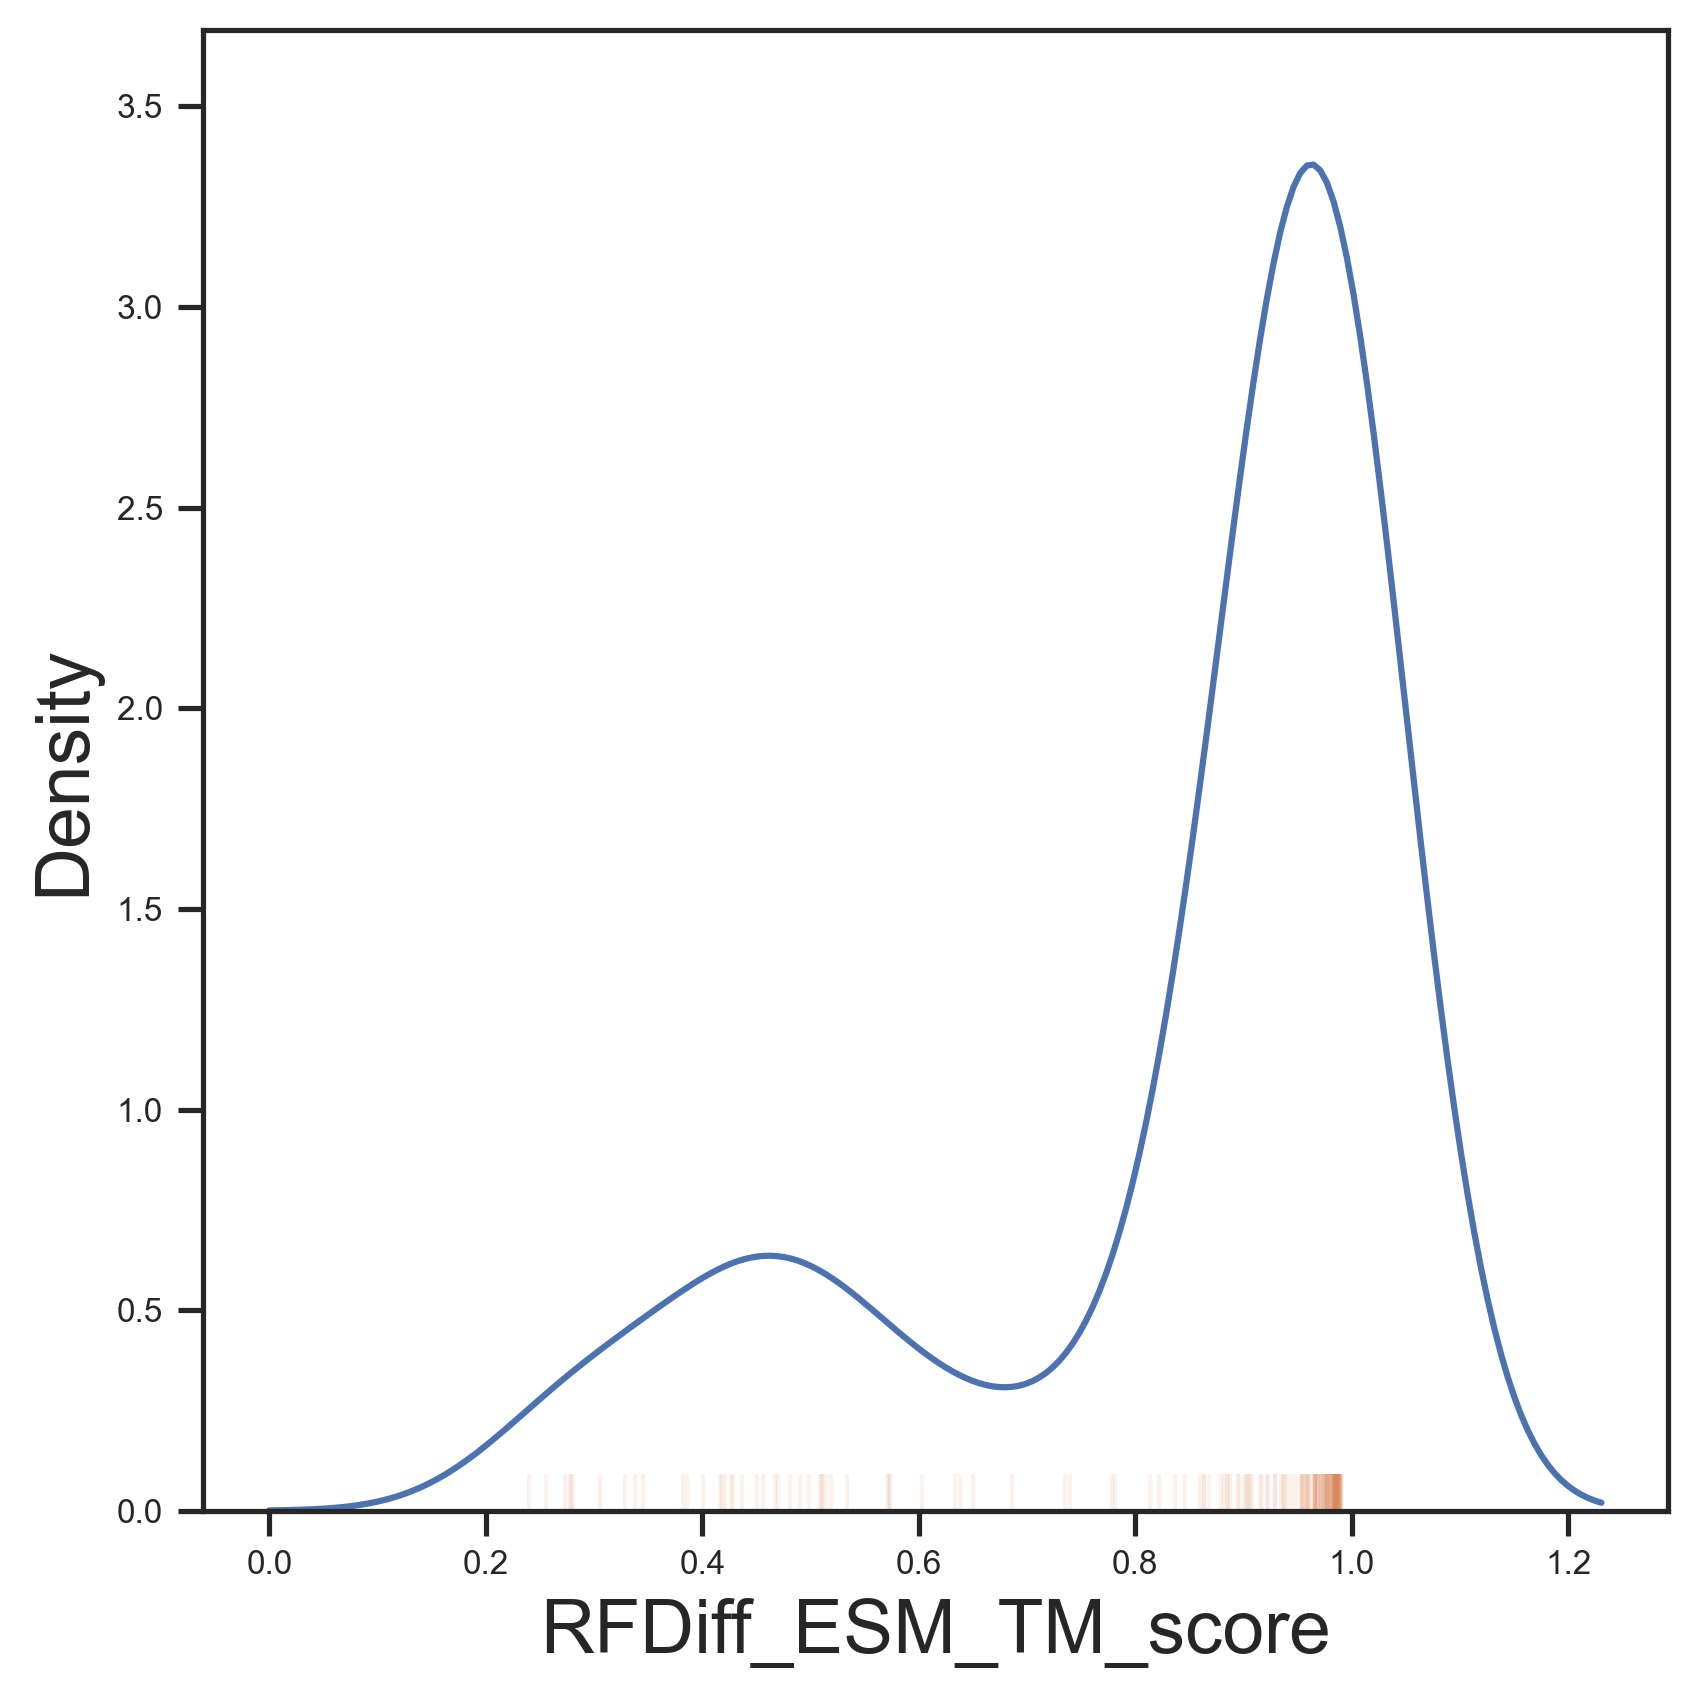

In [38]:
fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu='ESMFold_pLDDT'
df=final_df.copy()

sns.kdeplot(data=df,x='RFDiff_ESM_TM_score')
sns.rugplot(data=df,x='RFDiff_ESM_TM_score',alpha=0.1)

#plt.legend(title=hu,loc=(1.1,0.1))
plt.legend('',frameon=False)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.tight_layout()
#plt.savefig('output.svg',transparent=True,dpi=2000)


<Figure size 640x480 with 0 Axes>

<Figure size 19200x19200 with 0 Axes>

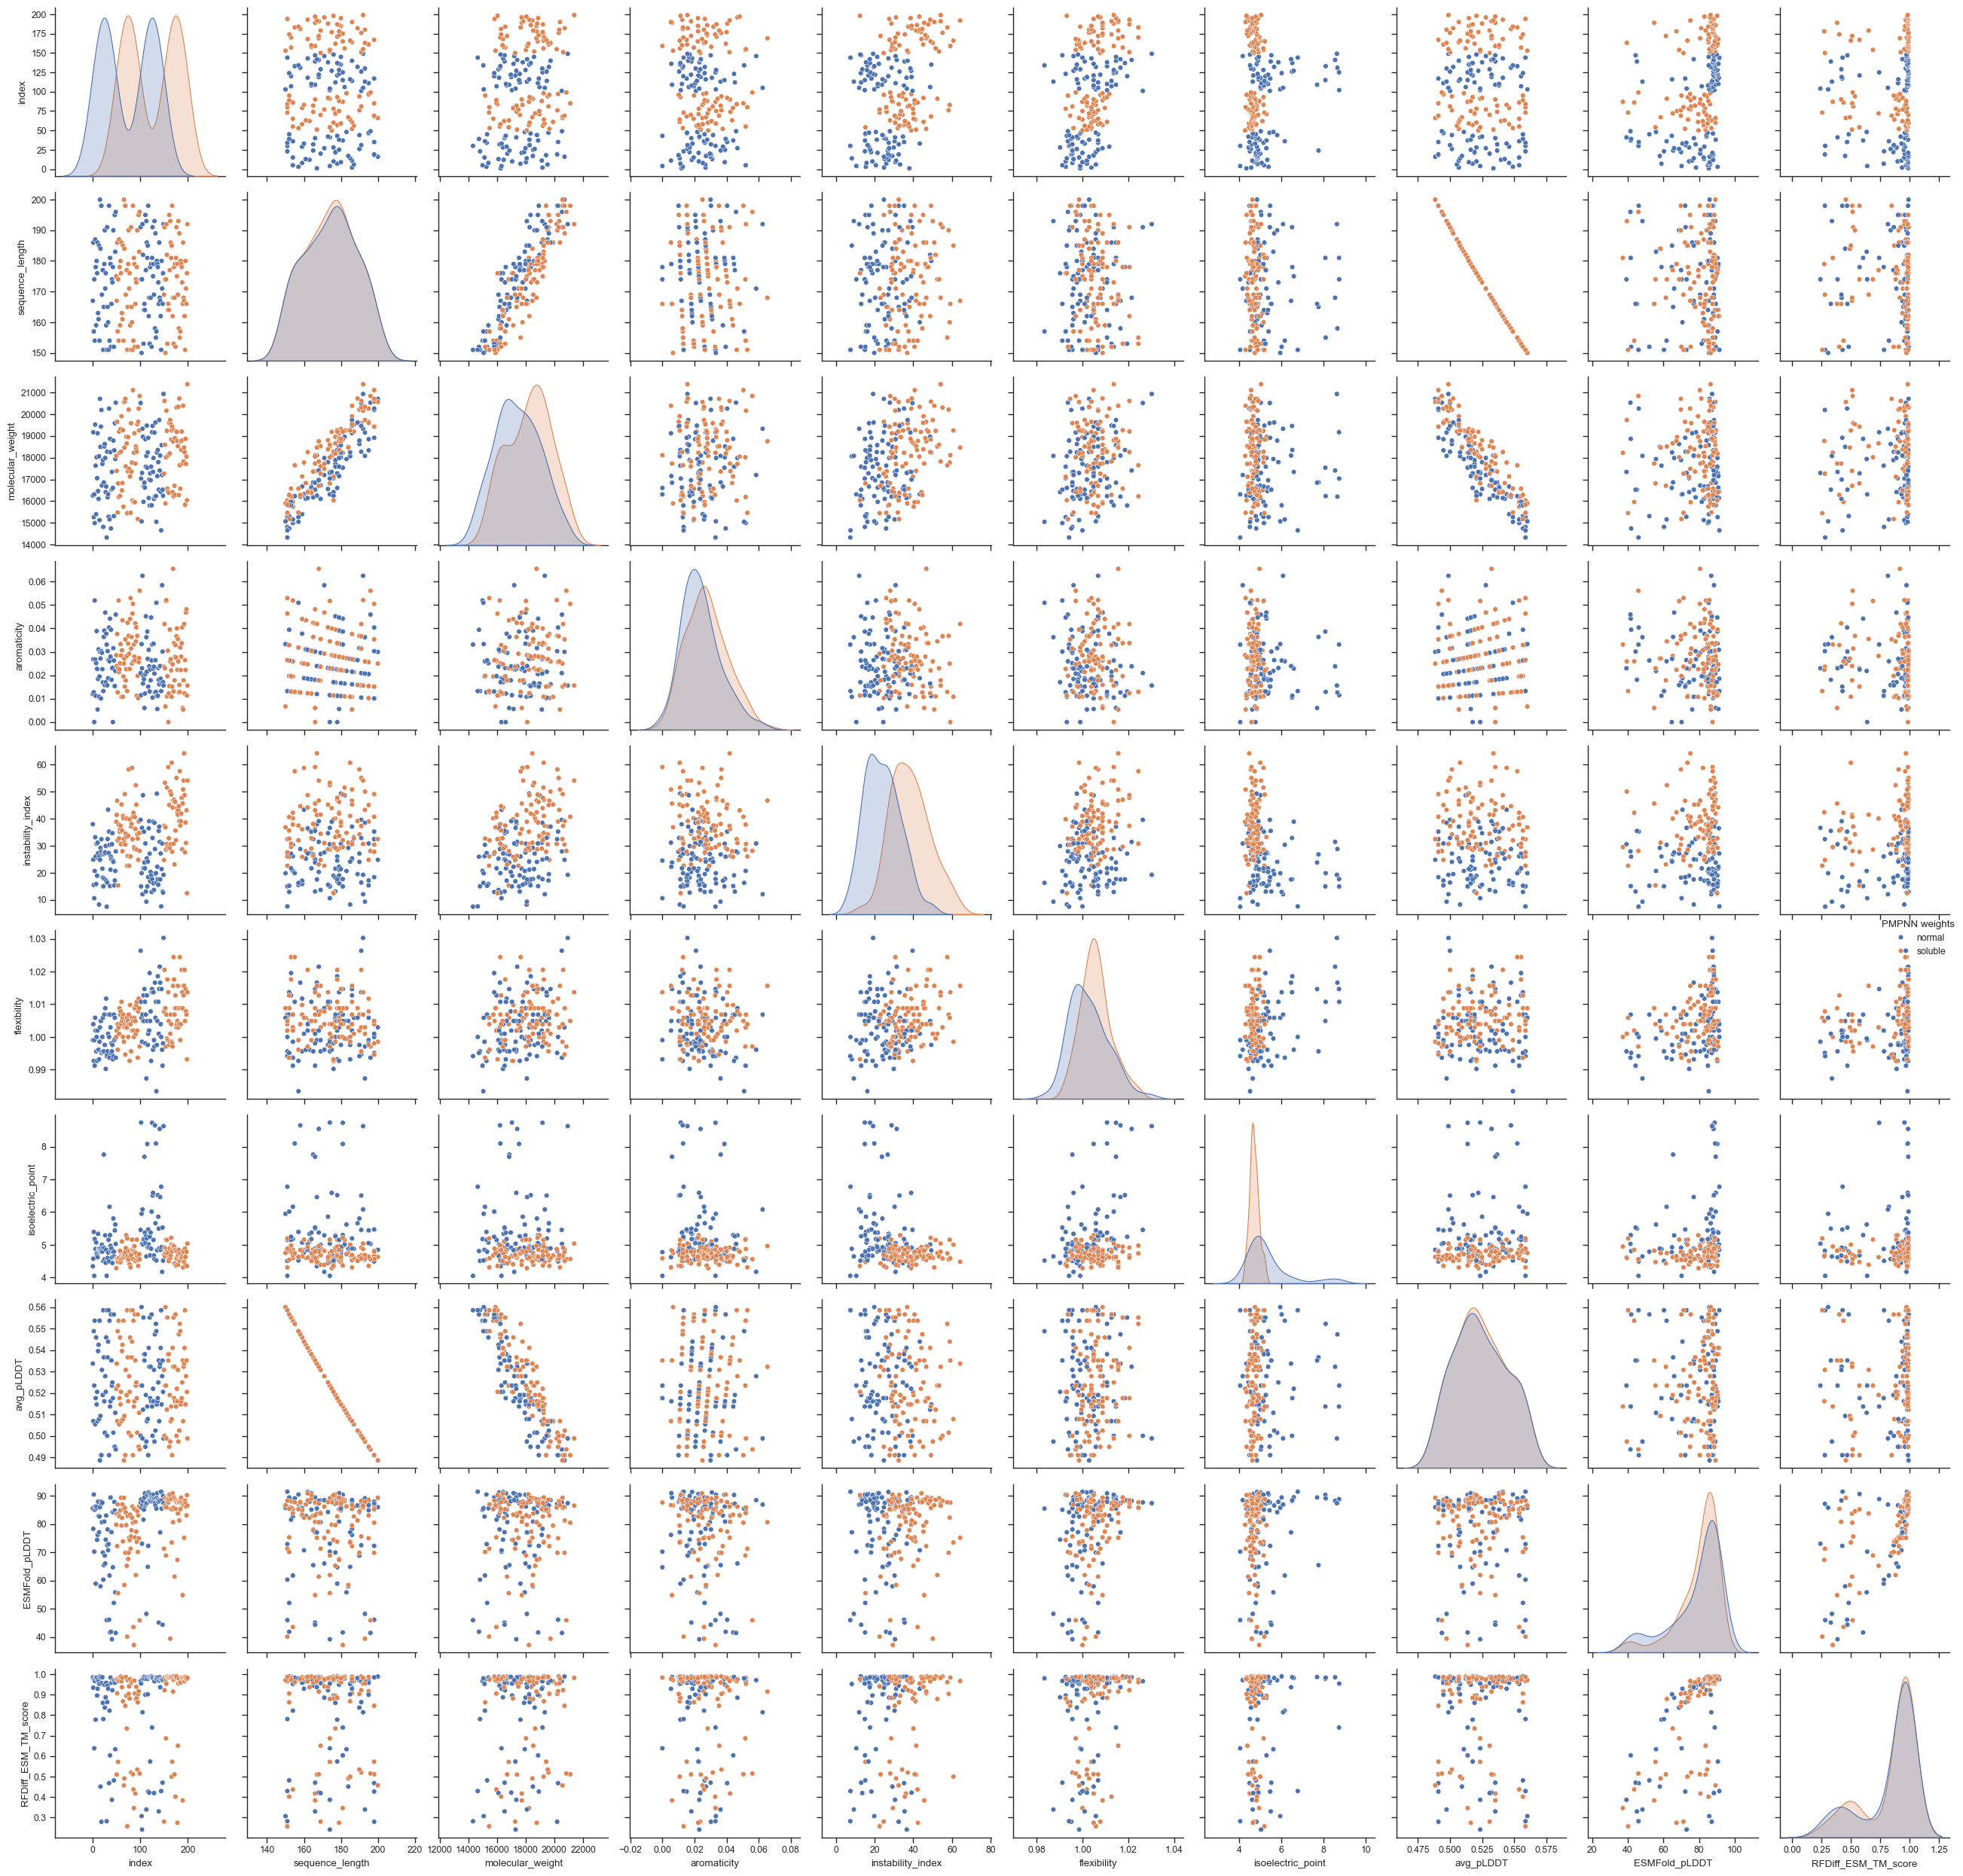

In [39]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(32,32),dpi=600) 
sns.pairplot(final_df, hue="PMPNN weights",)

plt.xticks(size=25)
plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_final_PMPNN_weights.png',transparent=True)
plt.show()

<Figure size 640x480 with 0 Axes>

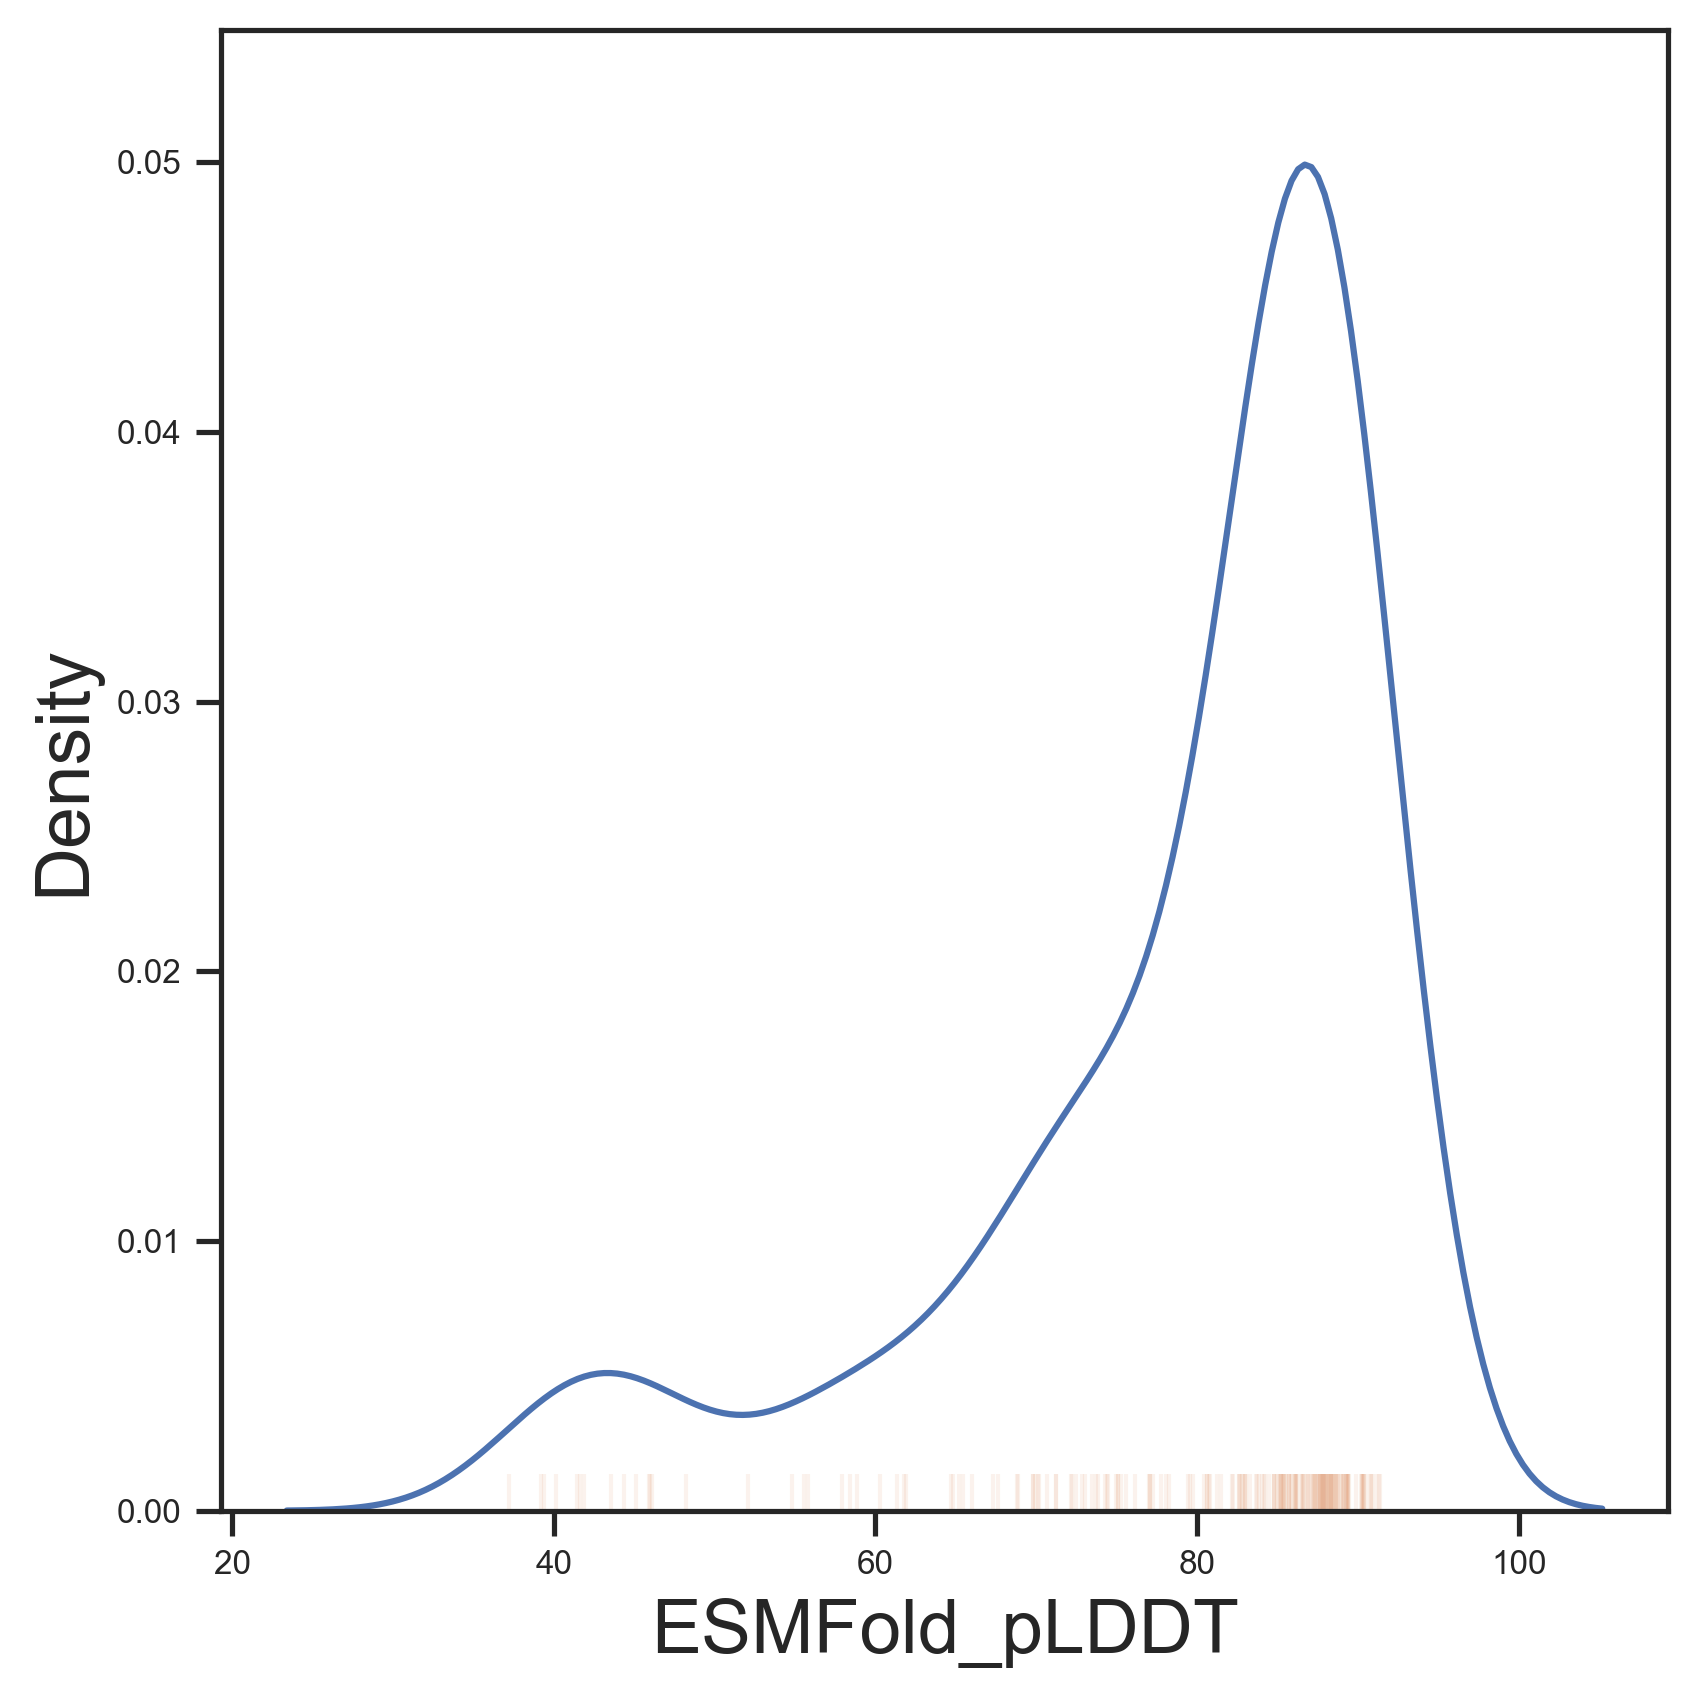

In [40]:
fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)

df=final_df.copy()

sns.kdeplot(data=df,x='ESMFold_pLDDT')
sns.rugplot(data=df,x='ESMFold_pLDDT',alpha=0.1)

#plt.legend(title=hu,loc=(1.1,0.1))
plt.legend('',frameon=False)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.tight_layout()
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [41]:
df_best

index pdb_file                                           sequence  \
2        3      _11  GADAAADACEAAARAVAAEAGMAVAVVRFTDKDSLAEARAAIAAAA...   
11      12       _2  MMGRVAVGGGTAGDNALAEAVAERLGPMAVATGATPEETIAAAREA...   
17      18      _25  SKAEEAEAKAVAATKAAMAEAGSAALGRVKAGKVPLLIIINSAAQS...   
20      21      _28  AILEEADVPVVEAAELAVKKLIEKTGKEELKVTLLAIGSDETLDYA...   
37      38      _43  MVSLGLGVAVAGADGDDVIESLRLLGAMAADLAKMAKGRGMAVSVG...   
45      46       _6  MKNVVPASIDVSGSSTLADVDADAAAARATIEAAAAAGNKVALSVN...   
59      60      _18  MKNIVVALFGSEVEATAEACRATEERVIELAKKEGAKVRTVAGGTP...   
99     101       _1  MFKEAVEAAKKATEAAKKATDKAEATKELGKAAGELYVAAGAASEG...   
100    102      _10  AALEAEKAAKKKEQLEKEKEATDEAQAKGLEAQALATEAGALGGHD...   
104    106      _14  ASPEEIREAAKRAIEAVEALVAAADAVLEAARTGNYEETMQEASRL...   
107    109      _17  MEENLELGKQLAGAVASLTVGTFDSLADTAKQIAKLLEEAKKALKS...   
108    110      _18  AEAEALLKGAEKAAKALEEAAKAAIAALKAGDIAAATKHMSDACLA...   
113    115      _22  AAAARAAHIAARAATAAAAAAMAAKAAEAYKKLAKEVAKDPKAKAL...   
116    118      _25  DAATKVAKEAREKCEEALKLDPLEGVRRCTEAFAALTAAVGTPETA...   
118    120      _27  AQEEVKKVAEKALAEAEAAIDKEGKNIAKAAAASPEEAEAAYKEIK...   
120    122      _29  GLQVLLGYISWGIEEEGAVGARKAGAEVYKTLKKAAEEIKKLGEET...   
121    123       _3  DLEATVKAAADELAKALKDLAAVVVAALTALAADPAARPALLELAR...   
122    124      _30  SAAAEAARLAKLKKEADEAGEKAAKAAEELREASVALVYKKTGDVK...   
124    126      _32  SAKEAAAKRVAATGAALLSTLAKIGRELAEREGEEVSRFRRRALSL...   
125    127      _33  SGLAAAAALAAGAAAGFLTVGEIAANAAENPETRAEASEKAANFAV...   
128    130      _36  SAERAAAVAAAADRIAAAAAGFAAAAERAFNAVAAGSPEVAELARA...   
131    133      _39  EEAKKLLKEAAAKAEEAKAAAKALGALAQQLAPVLSGGAVSAILEM...   
133    135      _40  MEEIAAAAEALAEAAAEAAKVGPLAQEAVLAAGNALMIAAGIAPEV...   
135    137      _42  MRVLELAREAARVAEKLKEAAIKAADKDKALYEKLAKAAALTAAAA...   
138    140      _45  AAAEEEERRKRQKELVEKIRALATAAADALTEAAALAEKAAEEAAK...   
139    141      _46  GPEEERKKKAEEILKKAKESAEDARKLAEAAAKALKEAAATSADLA...   
141    143      _48  EYGRLRRQMIEELTAAIANLSTAISNLNTALALANQLAAVDPALAT...   
144    146       _6  GGGAVQAAANADVNLAIAKEAAKEDEEKANAFAIAAALAAGVAGAE...   
146    148       _8  AALAAARAAMAAGAERIAAIVAEATADPEALAALGAALIAAGAAMS...   
150    152      _10  AAAAAEAARRREEQIERAREATGEAEAFGLEVVARCTAAGALGQLD...   
154    156      _14  ASPEEIRRAAEEVIRRLRELDRRAAAVLEAARTGSAAETAEEAARL...   
155    157      _15  SKLEKLKEEAKELGEEAIEALEKATEYLKKAYETLKSLKDDPEKAQ...   
156    158      _16  MMEAVRAAAERLKAAAASLATGCAFFANGVLKGSSGACCMGALSFG...   
157    159      _17  DERNIQLGKQLAGSAASLAVATLESAAETLEEVAELLEEAKELVES...   
159    161      _19  SAAERAEELLAEARRDLAAARAAEEAGLEDPSKRVGAAVTCAAAAA...   
160    162       _2  AKEQLKANAKETEELLNKANDALIDLARRVAEADGLVGSHLYLFAL...   
163    165      _22  DEEERQKHNEARAKACRAFAEMERRIAAALAALAAQAAADPKAKAL...   
166    168      _25  SMATEVAKEAARECEAALEGDPLEGVRRCLRALARLTEAVGSPETA...   
169    171      _28  KEKKLANLEIALESVEEAEKYIEEARKKAKDPEEVQRYLAEAAGHF...   
171    173       _3  SLEETVLREAEELVRALREFGDVAVRTLRALMANPADREAALLVAE...   
173    175      _31  AEEATRAAREASREALELTDELVALAEAGIAEGHEGAAAAGLAEAL...   
174    176      _32  SAREEAQRRVAETGAALASALGVIGKELAEEYGEEVHEFRYKAMDL...   
178    180      _36  TAEEAAKIAAAAEAIARATRGFTEDAIRAFNRVAAGSEEVAELARE...   
179    181      _37  AEAAAKAAQAKLSEYSTKAMEKLGEANSLLREALASSPEEAQELCL...   
181    183      _39  SRARELLEEAIELLEKAKELAEELEEEAKKNKEILSGGAVSAILEM...   
183    185      _40  MEDIEEAGVAMARAAIVAGKVSPLAQEIVLDAGNGLCIVAGAAPEV...   
186    188      _43  ATLEEAERLAEAAITAAKAAEEQAKLAKEYLEKDETKAAGYLSGAL...   
191    193      _48  EIGRLARQAADELTGAIAYLSEAIEELEKAIELLEELSKVEPEIAK...   
192    194      _49  LREEAVRAIREAVRLGEEAARTLAELAEKYKDDEKIQVAAGRAAGV...   
196    198       _8  SALAAARAVMDATADRIAAIIARCTADPATLAAVGEALRAAGAAMA...   

      score global_score seq_recovery  \
2    0.8781       1.2786       0.0573   
11   0.8097       1.1969       0.0736   
17   0.9604       1.2272       0.0657   
20   0.8816       1.2399       0.0734   
37   0.9446       1.2474 

In [42]:
df_best['RF_weights'].value_counts()

RF_weights
Normal    43
Beta       7
Name: count, dtype: int64

In [43]:
df_best['PMPNN weights'].value_counts()

PMPNN weights
normal     28
soluble    22
Name: count, dtype: int64

In [44]:
df_best=df_best.sort_values('ESMFold_pLDDT',ascending=False)

In [45]:
df_best = df_best.reset_index(drop=True)
df_best = df_best.reset_index(drop=False)

In [46]:
df_best

level_0  index pdb_file  \
0         0    143      _48   
1         1    118      _25   
2         2    110      _18   
3         3    168      _25   
4         4    162       _2   
5         5      3      _11   
6         6    115      _22   
7         7    123       _3   
8         8    198       _8   
9         9    148       _8   
10       10    127      _33   
11       11    171      _28   
12       12    124      _30   
13       13    109      _17   
14       14     38      _43   
15       15     60      _18   
16       16    135      _40   
17       17    152      _10   
18       18    130      _36   
19       19    133      _39   
20       20    158      _16   
21       21    165      _22   
22       22    185      _40   
23       23    173       _3   
24       24    102      _10   
25       25    161      _19   
26       26    156      _14   
27       27    140      _45   
28       28    146       _6   
29       29    137      _42   
30       30    120      _27   
31       31    193      _48   
32       32    194      _49   
33       33    141      _46   
34       34    176      _32   
35       35    126      _32   
36       36    106      _14   
37       37    122      _29   
38       38    157      _15   
39       39    175      _31   
40       40     18      _25   
41       41     12       _2   
42       42    180      _36   
43       43     46       _6   
44       44    181      _37   
45       45    188      _43   
46       46    183      _39   
47       47    101       _1   
48       48    159      _17   
49       49     21      _28   

                                             sequence   score global_score  \
0   EYGRLRRQMIEELTAAIANLSTAISNLNTALALANQLAAVDPALAT...  1.1170       1.3323   
1   DAATKVAKEAREKCEEALKLDPLEGVRRCTEAFAALTAAVGTPETA...  0.9239       1.2625   
2   AEAEALLKGAEKAAKALEEAAKAAIAALKAGDIAAATKHMSDACLA...  0.9458       1.2586   
3   SMATEVAKEAARECEAALEGDPLEGVRRCLRALARLTEAVGSPETA...  0.8889       1.2312   
4   AKEQLKANAKETEELLNKANDALIDLARRVAEADGLVGSHLYLFAL...  0.9623       1.2471   
5   GADAAADACEAAARAVAAEAGMAVAVVRFTDKDSLAEARAAIAAAA...  0.8781       1.2786   
6   AAAARAAHIAARAATAAAAAAMAAKAAEAYKKLAKEVAKDPKAKAL...  0.9073       1.2314   
7   DLEATVKAAADELAKALKDLAAVVVAALTALAADPAARPALLELAR...  0.9188       1.2453   
8   SALAAARAVMDATADRIAAIIARCTADPATLAAVGEALRAAGAAMA...  0.8453       1.1756   
9   AALAAARAAMAAGAERIAAIVAEATADPEALAALGAALIAAGAAMS...  0.8407       1.1844   
10  SGLAAAAALAAGAAAGFLTVGEIAANAAENPETRAEASEKAANFAV...  0.9013       1.2446   
11  KEKKLANLEIALESVEEAEKYIEEARKKAKDPEEVQRYLAEAAGHF...  0.9433       1.2521   
12  SAAAEAARLAKLKKEADEAGEKAAKAAEELREASVALVYKKTGDVK...  1.0300       1.3288   
13  MEENLELGKQLAGAVASLTVGTFDSLADTAKQIAKLLEEAKKALKS...  0.9546       1.2773   
14  MVSLGLGVAVAGADGDDVIESLRLLGAMAADLAKMAKGRGMAVSVG...  0.9446       1.2474   
15  MKNIVVALFGSEVEATAEACRATEERVIELAKKEGAKVRTVAGGTP...  0.8152       1.1830   
16  MEEIAAAAEALAEAAAEAAKVGPLAQEAVLAAGNALMIAAGIAPEV...  0.9452       1.2338   
17  AAAAAEAARRREEQIERAREATGEAEAFGLEVVARCTAAGALGQLD...  0.9321       1.2339   
18  SAERAAAVAAAADRIAAAAAGFAAAAERAFNAVAAGSPEVAELARA...  0.9014       1.1788   
19  EEAKKLLKEAAAKAEEAKAAAKALGALAQQLAPVLSGGAVSAILEM...  1.0051       1.2990   
20  MMEAVRAAAERLKAAAASLATGCAFFANGVLKGSSGACCMGALSFG...  0.9170       1.2095   
21  DEEERQKHNEARAKACRAFAEMERRIAAALAALAAQAAADPKAKAL...  0.9802       1.2549   
22  MEDIEEAGVAMARAAIVAGKVSPLAQEIVLDAGNGLCIVAGAAPEV...  0.9449       1.2342   
23  SLEETVLREAEELVRALREFGDVAVRTLRALMANPADREAALLVAE...  0.9510       1.2611   
24  AALEAEKAAKKKEQLEKEKEATDEAQAKGLEAQALATEAGALGGHD...  0.9868       1.2739   
25  SAAERAEELLAEARRDLAAARAAEEAGLEDPSKRVGAAVTCAAAAA...  0.8617       1.1924   
26  ASPEEIRRAAEEVIRRLRELDRRAAAVLEAARTGSAAETAEEAARL...  0.9145       1.2248   
27  AAAEEEERRKRQKELVEKIRALATAAADALTEAAALAEKAAEEAAK...  0.9580       1.2570   
28  GGGAVQAAANADVNLAIAKEAAKEDEEKANAFAIAAALAAGVAGAE...  0.9892       1.2735   
29  MRVLELAREAARVAEKLKEAAIKAADKDKALYEKLAKAAALTAAAA...  0.7645       1.1673   
30  

In [22]:
SngA_seq = 'LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPS'



In [23]:
SngA_seq[300:500]

'KCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCV'

In [ ]:
def write_fasta_files_AFpulldown(df):
    
    # Iterate over rows of the dataframe
    for index, row in df.iterrows():
        # Generate the filename for the FASTA file using the pdb_file column
        file_name = f"AF_pulldown.fasta"
        file_name_txt = f"AF_pulldown.txt"
        
        # Write the sequence to the FASTA file
        with open(file_name, "a") as fasta_file:
            fasta_file.write(f">{index}\n")
            fasta_file.write(f"{row['sequence']}\n")
            
        # Write the sequence to the FASTA file
        with open(file_name_txt, "a") as fasta_file:
            fasta_file.write(f"{index}\n")
            
write_fasta_files_AFpulldown(df_best)


# Go run AF pulldown

In [60]:
df_AFpulldown_results = pd.read_csv('./AlphaPulldown/predictions_with_good_interpae.csv')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

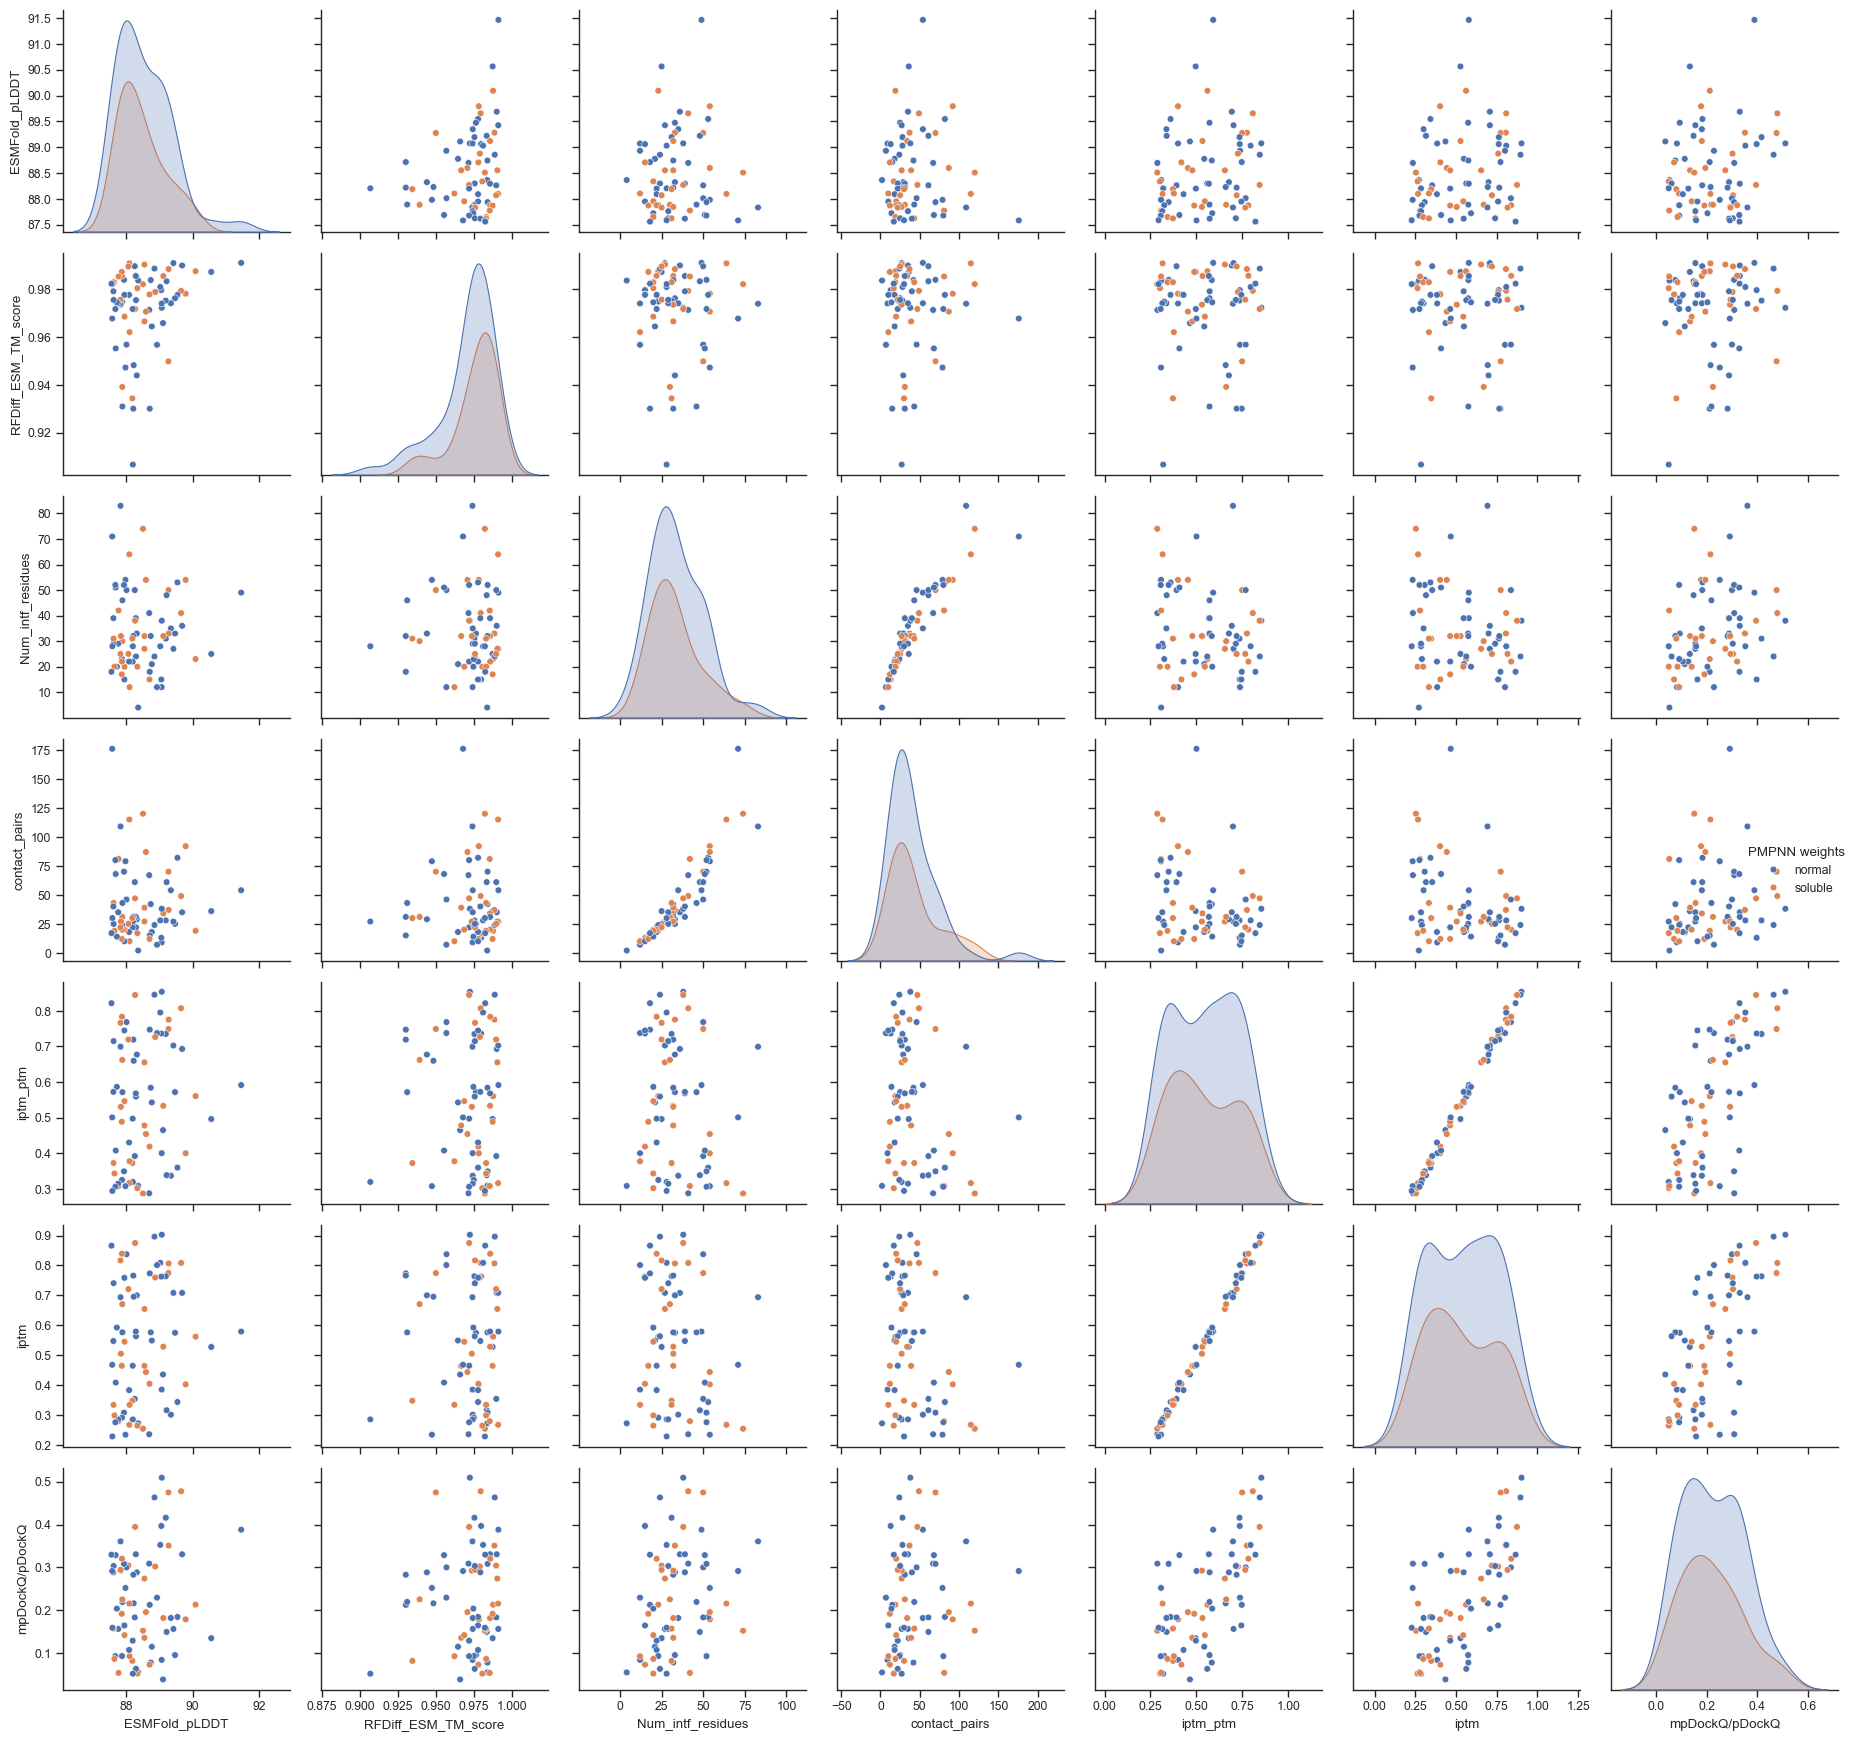

In [ ]:

df_AFpulldown_results['jobs_index'] = df_AFpulldown_results['jobs'].str.extract('(\d+)').astype(int)
df_AFpulldown_results=df_AFpulldown_results.sort_values('jobs_index')
df_AFpulldown_results=df_AFpulldown_results.set_index('jobs_index')
df_results=df_best.merge(df_AFpulldown_results,left_index=True,right_index=True)
df_results=df_results[['index', 'jobs',
      'ESMFold_pLDDT', 'RFDiff_ESM_TM_score', 
       'Num_intf_residues', 'Polar', 'Hydrophobhic', 'Charged',
       'contact_pairs', ' sc', ' hb', ' sb', ' int_solv_en', ' int_area',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ',
                    
        'pdb_file', 'sequence', 'sequence_length',

       'RDiff_pdb_file_path', 'molecular_weight', 'aromaticity',
       'instability_index', 'flexibility', 'isoelectric_point',
      
        'PMPNN weights', 'score', 'global_score',   'seq_recovery',
         'RF_weights', 
        'fasta_path', 'fasta_file_path','ESM_pdb_path', 'RFDiff_binder_pdb_path',]]
plot_df = df_results[[
      'ESMFold_pLDDT', 'RFDiff_ESM_TM_score', 
       'Num_intf_residues', 
       'contact_pairs',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ',
        'PMPNN weights', 
       ]]
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(10,10),dpi=600) 
sns.pairplot(plot_df, hue="PMPNN weights",)

#plt.xticks(size=25)
#plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_AFpulldown_PMPNN_weights.png',transparent=True)
plt.show()

In [ ]:
df_results.columns

In [ ]:
df=df_results.copy()

cut_TM = 0.5 #0.26
cut_pLDDT = 0.23

TM_col_name = 'iptm'
pLDDT_col_name = 'mpDockQ/pDockQ'
df_TM = df[df[TM_col_name]>cut_TM]
df_pLDDT = df_TM[df_TM[pLDDT_col_name]>cut_pLDDT]
df_best = df_pLDDT[df_pLDDT[TM_col_name]>cut_TM]

fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu=pLDDT_col_name

plt.axhline(y=cut_pLDDT,zorder=-2)
plt.axvline(x=cut_TM,zorder=-2)

sns.scatterplot(data=df,x=TM_col_name,y=pLDDT_col_name,hue=hu,palette='RdYlBu',edgecolor='k',zorder=1)
#sns.scatterplot(data=df_best,x=TM_col_name,y=pLDDT_col_name

sns.kdeplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',bw_adjust=0.65,levels=5,alpha=0.2,zorder=-1)
#sns.scatterplot(data=df,x='TM-scores',y='pLDDT',sizes='Length')
#sns.lmplot(data=df,x='TM-scores',y='pLDDT',ci='sd')
plt.legend('',frameon=False)
#plt.legend(title=hu,loc=(1.1,0.1))

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [ ]:
df_results.columns

In [ ]:
!pwd

In [ ]:
df_to_order=df_results.copy()


In [ ]:
df_to_order= df_to_order[df_to_order['mpDockQ/pDockQ']>0.23]
df_to_order= df_to_order[df_to_order['iptm']>0.5]

In [ ]:
df_to_order['sequence']

In [ ]:
def add_Met(sequence):
    if sequence.startswith('M'):
        return sequence
    else:
        return 'M' + sequence

# Apply the function to the 'sequence' column
df_to_order['sequence'] = df_to_order['sequence'].apply(add_Met)

In [ ]:
df_to_order.to_excel('df_to_order.xlsx')

In [ ]:
df_to_genscript = df_to_order[['index','sequence', 'sequence_length', 
       'molecular_weight', 'aromaticity', 'instability_index', 'flexibility',
       'isoelectric_point']]

In [ ]:
df_to_genscript.rename(columns={"index": "Design Number / Name"})
df_to_genscript.to_excel('genscript_sheet.xlsx')